
# Week 3 - Discovering higher-level Patterns (Topic Modeling & Clustering)

The first 2 weeks have primarily used the word count of documents as their measure, such as counting the number of "positive" and "negative" words to determine sentiment.

This week, we learn a second kind of document representation in clusters or topics. First, we take a text corpus that we have developed and discovery emergent clusters through a process known as clustering or partitioning. We pilot this here both with a well-known *flat* clustering method, `kmeans`, and also a *hierarchical* approach, `Ward's (minimum variance) method`. We will demonstrate a simple (graphical) approach to identifying optimal cluster number, the sillhouette method, and evaluate the quality of unsupervised clusters on labeled data. Next, we will explore a method of two dimensional content clustering called topic modeling (e.g., words cluster in topics; topics cluster in documents). This statistical technique models and computationally induces *topics* from data, which are sparse distributions over (nonexclusive clusters of) words, from which documents can formally be described as sparse mixtures. We will explore these topics and consider their utility for understanding trends within a corpus. We will consider how to construct models that take document cluster and topic loadings as predictive features, the basis of influence metrics and dynamically over time.

For this notebook we will be using the following packages:

In [4]:
%%capture
#Special module written for this class
#This provides access to data and to helper functions from previous weeks
#Make sure you update it before starting this notebook

! pip install -U git+git://github.com/UChicago-Computational-Content-Analysis/lucem_illud.git
import lucem_illud #

#All these packages need to be installed from pip
#These are all for the cluster detection
import sklearn
import sklearn.feature_extraction.text
import sklearn.pipeline
import sklearn.preprocessing
import sklearn.datasets
import sklearn.cluster
import sklearn.decomposition
import sklearn.metrics

import scipy #For hierarchical clustering and some visuals
#import scipy.cluster.hierarchy
import gensim#For topic modeling
import requests #For downloading our datasets
import numpy as np #for arrays
import pandas #gives us DataFrames
import matplotlib.pyplot as plt #For graphics
import matplotlib.cm #Still for graphics
import seaborn as sns #Makes the graphics look nicer

#This 'magic' command makes the plots work better
#in the notebook, don't use it outside of a notebook.
#Also you can ignore the warning, it
%matplotlib inline

import itertools
import json

# Getting our corpora

To begin, we will use a well known corpus of testing documents from the *20 Newsgroups corpus*, a dataset commonly used to illustrate text applications of text clustering and classification. This comes packaged with sklearn and comprises approximately 20,000 newsgroup documents, partitioned (nearly) evenly across 20 newsgroups. It was originally collected by Ken Lang, probably for his 1995 *Newsweeder: Learning to filter netnews* paper. The data is organized into 20 distinct newsgroups, each corresponding to a different topic. Some of the newsgroups are very closely related (e.g. comp.sys.ibm.pc.hardware / comp.sys.mac.hardware), while others are unrelated (e.g misc.forsale / soc.religion.christian). 

In [ ]:
newsgroups = sklearn.datasets.fetch_20newsgroups(subset='train', data_home = '../data/scikit_learn_data')
print(dir(newsgroups))

['DESCR', 'data', 'filenames', 'target', 'target_names']


We can ascertain the categories with `target_names` or the actual files with `filenames`

In [ ]:
print(newsgroups.target_names)
print(len(newsgroups.data))

['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt', 'sci.electronics', 'sci.med', 'sci.space', 'soc.religion.christian', 'talk.politics.guns', 'talk.politics.mideast', 'talk.politics.misc', 'talk.religion.misc']
11314


We will start by converting the provided data into pandas DataFrames.

First we reduce our dataset for this analysis by dropping some extraneous information and converting it into a DataFrame.

In [ ]:
newsgroupsCategories = ['comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos']

newsgroupsDF = pandas.DataFrame(columns = ['text', 'category', 'source_file'])

for category in newsgroupsCategories:
    print("Fetching data for: {}".format(category))
    ng = sklearn.datasets.fetch_20newsgroups(subset='train', categories = [category], remove=['headers', 'footers', 'quotes'], data_home = '../data/scikit_learn_data/')
    newsgroupsDF = newsgroupsDF.append(pandas.DataFrame({'text' : ng.data, 'category' : [category] * len(ng.data), 'source_file' : ng.filenames}), ignore_index=True)

#Creating an explicit index column for later

#newsgroupsDF['index'] = range(len(newsgroupsDF))
#newsgroupsDF.set_index('index', inplace = True)
print(len(newsgroupsDF))
newsgroupsDF[:10]

Fetching data for: comp.sys.mac.hardware
Fetching data for: comp.windows.x
Fetching data for: misc.forsale
Fetching data for: rec.autos
2350


,text,category,source_file
0,"\tIn certain Apple 13"" RGB monitors there has ...",comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...
1,Does anyone know how to reach Micron? I am in...,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...
2,Hi there!\n\nCould some kind soul tell me what...,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...
3,"""auto\nfrom",comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...
4,\n\n Don't believe the hype. There is no su...,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...
5,What is the value of an SE (HDFD) 4/20?\n\n-David,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...
6,\n\nF A Q !\n\nReference:\nNewsgroups: comp.sy...,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...
7,"\n\n\n Nope. The Apple 16"" monitor does not...",comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...
8,\n\nIs it a hidden option? I'm using PowerStr...,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...
9,\n\n\nThe previous article referred to the fac...,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...


Next, we can convert the documents into word count vectors (e.g., *soc.religion.christian message a* might contain 3 mentions of "church", 2 of "jesus", 1 of "religion", etc., yielding a CountVector=[3,2,1,...])

In [ ]:
#First it needs to be initialized
ngCountVectorizer = sklearn.feature_extraction.text.CountVectorizer()
#Then trained
newsgroupsVects = ngCountVectorizer.fit_transform(newsgroupsDF['text'])
print(newsgroupsVects.shape)

(2350, 23525)


In [ ]:
newsgroupsVects[0]

<1x23525 sparse matrix of type '<class 'numpy.int64'>'
	with 45 stored elements in Compressed Sparse Row format>

I'm pretty sure that you're very familiar with the cell above now, but let's go through the concepts again. 

What do we want to do here? We want to do vectorization, i.e., converting texts into numerical features (vectors) as required by machine learning algorithms. And this is what feature_extraction module does: to extract features from texts in a format as required by ML algorithms. feature_extraction module has four classes: CountVectorizer, DictVectorizer, TfidfVectorizer, and FeatureHasher. Here, we use CountVectorizer, but we'll also use TfidfVectorizer as well below.

There are various strategies by which we extract features. Here, we use CountVectorizer, and, in particular, we use 'Bag of Words' representation. In other words, the features we hope to extract from the texts are each individual token occurrence frequency. We simply count the the occurrence of each token in each document. So, here, we get a document-term-matrix, in which documents are characterized by the occurrences of tokens. Other forms of features, such as the relative position information of words, are ignored. We'll see other types of representations and strategies as well soon, such as N-gram (by the way, we can do n-gram with CountVectorizer. CountVectorizer class takes a set of parameters, such as analyzer, which you can specify the n-gram). 

the first line of the cell above instantiate a class, CountVectorizer(). In other words, you created an instance, or realization of a class. What is a class and what does instantiation mean? That's a long story, maybe for next time.

This gives us a matrix with row a document and each column a word. The matrix is mostly zeros, so we store it as a sparse matrix, a data structure that contains and indexes only the nonzero entries.

In [ ]:
newsgroupsVects

<2350x23525 sparse matrix of type '<class 'numpy.int64'>'
	with 177750 stored elements in Compressed Sparse Row format>

We can use the normal operations on this sparse matrix or convert it to normal matrix (not recommended for large sparse matrices :-)

In [ ]:
newsgroupsVects[:10,:20].toarray()

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

What is the toarray() function here? It's similar to todense()--todense() and toarray() both returns a dense representation of a matrix; however, todense() returns a matrix representation while toarray() returns a ndarray representation.

We can also lookup the indices of different words using the Vectorizer

In [ ]:
ngCountVectorizer.vocabulary_.get('vector')

21647

There are some more interesting things to do...

Lets start with [term frequency–inverse document frequency](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html)(tf-idf), a method for weighting document-distinguishing words.

In [ ]:
#initialize
newsgroupsTFTransformer = sklearn.feature_extraction.text.TfidfTransformer().fit(newsgroupsVects)
#train
newsgroupsTF = newsgroupsTFTransformer.transform(newsgroupsVects)
print(newsgroupsTF.shape)

(2350, 23525)


This gives us the tf-idf for each word in each text

In [ ]:
list(zip(ngCountVectorizer.vocabulary_.keys(), newsgroupsTF.data))[:20]

[('in', 0.08265545268171724),
 ('certain', 0.05464092321093494),
 ('apple', 0.19706119834212132),
 ('13', 0.05749878121929968),
 ('rgb', 0.07820822067701588),
 ('monitors', 0.0749569030656185),
 ('there', 0.10567912764152107),
 ('has', 0.1109950967372947),
 ('been', 0.05330795380898169),
 ('problem', 0.21470375597395805),
 ('with', 0.09901319943986409),
 ('the', 0.19389877721110985),
 ('high', 0.1817286448065436),
 ('voltage', 0.19389877721110985),
 ('capasitor', 0.33279218254193177),
 ('knows', 0.18819404816424326),
 ('about', 0.08243502153417578),
 ('this', 0.1619412292430009),
 ('and', 0.13074268623716792),
 ('is', 0.16299450361806797)]

Let's see what we're doing here. First, you need to know what vocabulary\_ does. vocabulary\_ is an attribute of the CountVectorizer, which gives you a mapping of terms to feature indices. It gives you all the terms and their feature indices, so it's a dictionary. So, by doing "ngCountVectorizer.vocabulary\_.keys()", we get the keys of the dictionary, which are the terms. 

At first glance, there appears to be a lot of garbage littering this unordered list with unique words and stopwords. Note, however, that words like *apple*, *rgb*, and *voltage* distinguish this newsgroup document, while stopwords post a much lower weight. Note that we could filter out stop words, stem and lem our data before vectorizering, or we can instead use tf-idf to filter our data (or **both**). For exact explanation of all options look [here](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html). To prune this matrix of features, we now limit our word vector to 1000 words with at least 3 occurrences, which do not occur in more than half of the documents. There is an extensive science and art to feature engineering for machine learning applications like clustering.

In [ ]:
#initialize
ngTFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=0.5, max_features=1000, min_df=3, stop_words='english', norm='l2')
#train
newsgroupsTFVects = ngTFVectorizer.fit_transform(newsgroupsDF['text'])

Lets look at the matrix

In [ ]:
newsgroupsDF['text']

0       \tIn certain Apple 13" RGB monitors there has ...
1       Does anyone know how to reach Micron?  I am in...
2       Hi there!\n\nCould some kind soul tell me what...
3                                             "auto\nfrom
4       \n\n    Don't believe the hype. There is no su...
                              ...                        
2345    I was wondering if anyone out in net-land have...
2346    \n\n\n\n\nI sold my '86 Sprint last April with...
2347    Actually I wasn't too surprised, since I bough...
2348    \n\nI couldnt agree more.  That is how it SHOU...
2349    \nWarren Brown, the Washington Post's auto wri...
Name: text, Length: 2350, dtype: object

The matrix is much smaller now, only 1000 words, but the same number of documents

We can still look at the words:

In [ ]:
try:
    print(ngTFVectorizer.vocabulary_['vector'])
except KeyError:
    print('vector is missing')
    print('The available words are: {} ...'.format(list(ngTFVectorizer.vocabulary_.keys())[:10]))

vector is missing
The available words are: ['certain', 'apple', '13', 'monitors', 'problem', 'high', 'cost', 'bad', 'got', 'local'] ...


This is a reasonable matrix of features with which to begin identifying clusters.

# Flat Clustering with $K$-means

Lets start with $k$-means, an approach that begins with random clusters of predefined number, then iterates cluster reassignment and evaluates the new clusters relative to an objective function, recursively.

To do this we will need to know how many clusters we are looking for. Here the *true number* of clusters is 4. Of course, in most cases you would not know the number in advance.

In [ ]:
numClusters = len(set(newsgroupsDF['category']))
numClusters

4

Then we can initialize our cluster finder

In [ ]:
#k-means++ is a better way of finding the starting points
#We could also try providing our own
km = sklearn.cluster.KMeans(n_clusters=numClusters, init='k-means++')

And now we can calculate the clusters

In [ ]:
km.fit(newsgroupsTFVects)

KMeans(n_clusters=4)

Once we have the clusters, we can evaluate them with a variety of metrics that sklearn provides. We will look at a few, including *Homogeneity*, *Completeness*, *V-measure* and *Adjusted Rand Score*. 

*Homogeneity* is a measure that grows (from 0 to 1) to the degree that all of its clusters contain only data points which are members of a single class (e.g., newsgroup). 

*Completeness* is *Homogeneity's* converse: a measure that grows (0 to 1) to the degree that all data points of a given class are also elements of the same cluster.

The *V-measure* is the harmonic mean of *Homogeniety* and *Completeness* ($v = 2 * (homogeneity * completeness) / (homogeneity + completeness$).

the *Adjusted Rand Score* is built atop the *Rand Index (RI)*, which computes the similarity between two clusterings by considering all pairs of samples and counting pairs assigned in the same or different clusters in the predicted and true clusterings (e.g., actual newsgroups). The *RI* is then adjusted for chance as follows:
$ARI = (RI - RI_{expected}) / (max(RI) - RI_{expected})$.
The Adjusted Rand Index is thus ensured to have a value close to 0.0 for random labeling independent of the number of clusters and samples, 1.0 when the clusterings are identical, and -1.0 when they are as bad (i.e., cross-cutting) as they can be.

In [ ]:
print("The available metrics are: {}".format([s for s in dir(sklearn.metrics) if s[0] != '_']))
print("For our clusters:")
print("Homogeneity: {:0.3f}".format(sklearn.metrics.homogeneity_score(newsgroupsDF['category'], km.labels_)))
print("Completeness: {:0.3f}".format(sklearn.metrics.completeness_score(newsgroupsDF['category'], km.labels_)))
print("V-measure: {:0.3f}".format(sklearn.metrics.v_measure_score(newsgroupsDF['category'], km.labels_)))
print("Adjusted Rand Score: {:0.3f}".format(sklearn.metrics.adjusted_rand_score(newsgroupsDF['category'], km.labels_)))

The available metrics are: ['ConfusionMatrixDisplay', 'DetCurveDisplay', 'DistanceMetric', 'PrecisionRecallDisplay', 'RocCurveDisplay', 'SCORERS', 'accuracy_score', 'adjusted_mutual_info_score', 'adjusted_rand_score', 'auc', 'average_precision_score', 'balanced_accuracy_score', 'brier_score_loss', 'calinski_harabasz_score', 'check_scoring', 'classification_report', 'cluster', 'cohen_kappa_score', 'completeness_score', 'confusion_matrix', 'consensus_score', 'coverage_error', 'd2_tweedie_score', 'davies_bouldin_score', 'dcg_score', 'det_curve', 'euclidean_distances', 'explained_variance_score', 'f1_score', 'fbeta_score', 'fowlkes_mallows_score', 'get_scorer', 'hamming_loss', 'hinge_loss', 'homogeneity_completeness_v_measure', 'homogeneity_score', 'jaccard_score', 'label_ranking_average_precision_score', 'label_ranking_loss', 'log_loss', 'make_scorer', 'matthews_corrcoef', 'max_error', 'mean_absolute_error', 'mean_absolute_percentage_error', 'mean_gamma_deviance', 'mean_pinball_loss', 'me

You can evaluate these for different clustering solutions ($1-N$ clusters). You can also interrogate the alignment between specific documents and their cluster assignments by adding the cluster labels to the pandas dataframe.

In [ ]:
newsgroupsDF['kmeans_predictions'] = km.labels_
newsgroupsDF

,text,category,source_file,kmeans_predictions
0,"\tIn certain Apple 13"" RGB monitors there has ...",comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...,0
1,Does anyone know how to reach Micron? I am in...,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...,0
2,Hi there!\n\nCould some kind soul tell me what...,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...,0
3,"""auto\nfrom",comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...,0
4,\n\n Don't believe the hype. There is no su...,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...,0
...,...,...,...,...
2345,I was wondering if anyone out in net-land have...,rec.autos,../data/scikit_learn_data/20news_home/20news-b...,0
2346,\n\n\n\n\nI sold my '86 Sprint last April with...,rec.autos,../data/scikit_learn_data/20news_home/20news-b...,1
2347,"Actually I wasn't too surprised, since I bough...",rec.autos,../data/scikit_learn_data/20news_home/20news-b...,1
2348,\n\nI couldnt agree more. That is how it SHOU...,rec.autos,../data/scikit_learn_data/20news_home/20news-b...,0


We can also look at the distinguishing features in each cluster:

In [ ]:
km.cluster_centers_.argsort()[:, ::-1]

array([[481, 880, 528, ..., 466, 970, 894],
       [161, 165, 315, ..., 668, 156, 127],
       [968, 791, 575, ..., 844, 954, 252],
       [768,   0, 607, ..., 332, 337, 387]])

In [ ]:
terms = ngTFVectorizer.get_feature_names()
print("Top terms per cluster:")
order_centroids = km.cluster_centers_.argsort()[:, ::-1] #flip the sequence of the column
for i in range(numClusters):
    print("Cluster %d:" % i)
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind])
    print('\n')

Top terms per cluster:
Cluster 0:
 know
 thanks
 mac
 just
 does
 drive
 like
 apple
 don
 new


Cluster 1:
 car
 cars
 engine
 like
 just
 good
 think
 don
 oil
 dealer


Cluster 2:
 window
 server
 motif
 use
 using
 widget
 program
 application
 like
 code


Cluster 3:
 sale
 00
 offer
 shipping
 condition
 new
 asking
 interested
 price
 email




Let's construct a visualization of the clusters. First, we will first reduce the
dimensionality of the data using principal components analysis (PCA).

In [ ]:
PCA = sklearn.decomposition.PCA
pca = PCA(n_components = 2).fit(newsgroupsTFVects.toarray())
reduced_data = pca.transform(newsgroupsTFVects.toarray())

The cell below is optional. It allows you to do a biplot

In [ ]:
components = pca.components_
keyword_ids = list(set(order_centroids[:,:10].flatten())) #Get the ids of the most distinguishing words(features) from your kmeans model.
words = [terms[i] for i in keyword_ids]#Turn the ids into words.
x = components[:,keyword_ids][0,:] #Find the coordinates of those words in your biplot.
y = components[:,keyword_ids][1,:]

Then, let's build a color map for the true labels.

In [ ]:
colordict = {
'comp.sys.mac.hardware': 'red',
'comp.windows.x': 'orange',
'misc.forsale': 'green',
'rec.autos': 'blue',
    }
colors = [colordict[c] for c in newsgroupsDF['category']]
print("The categories' colors are:\n{}".format(colordict.items()))

The categories' colors are:
dict_items([('comp.sys.mac.hardware', 'red'), ('comp.windows.x', 'orange'), ('misc.forsale', 'green'), ('rec.autos', 'blue')])


Let's plot the data using the true labels as the colors of our data points.

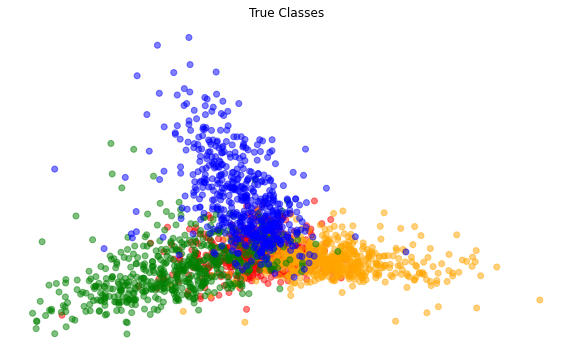

In [ ]:
fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
ax.scatter(reduced_data[:, 0], reduced_data[:, 1], color = colors, alpha = 0.5, label = colors)
plt.xticks(())
plt.yticks(())
plt.title('True Classes')
plt.show()

One nice thing about PCA is that we can also do a biplot and map our feature
vectors to the same space.

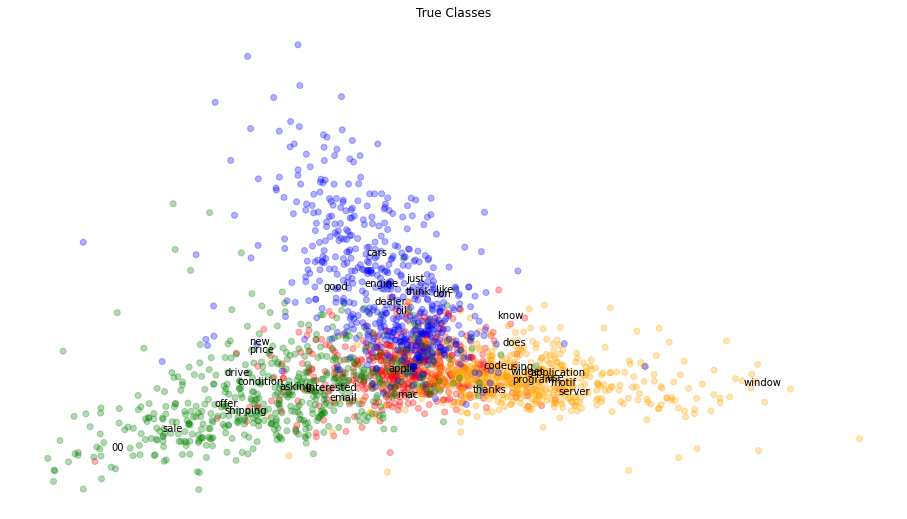

In [ ]:
fig = plt.figure(figsize = (16,9))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
ax.scatter(reduced_data[:, 0], reduced_data[:, 1], color = colors, alpha = 0.3, label = colors)
for i, word in enumerate(words):
    ax.annotate(word, (x[i],y[i]))
plt.xticks(())
plt.yticks(())
plt.title('True Classes')
plt.show()

Let's do it again with predicted clusters.

In [ ]:
colors_p = [colordict[newsgroupsCategories[l]] for l in km.labels_]

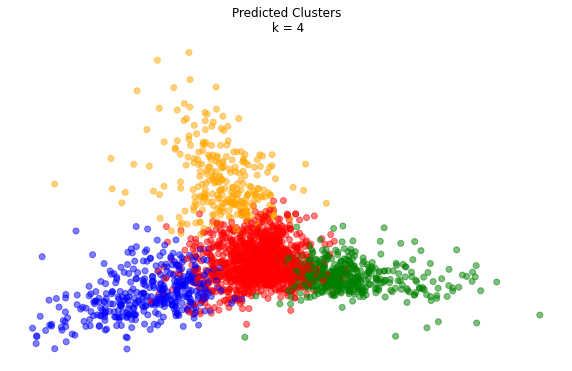

In [ ]:
fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], color = colors_p, alpha = 0.5)
plt.xticks(())
plt.yticks(())
plt.title('Predicted Clusters\n k = 4')
plt.show()

Let's try with 3 clusters.

In [ ]:
km3 = sklearn.cluster.KMeans(n_clusters= 3, init='k-means++')
km3.fit(newsgroupsTFVects.toarray())

KMeans(n_clusters=3)

# Selecting Cluster Number

We can select an optimal cluster number by identifying the lowest of the metrics listed above (e.g., V-measure), but often you don't have "ground truth" or labeled data. For identifying the "best" number of clusters in an unsupervised way, we demonstrate the Silhouette method. Many other methods also exist (e.g., Bayesian Information Criteria or BIC, the visual "elbow criteria", etc.)

First we will define a helper function:

In [ ]:
def plotSilhouette(n_clusters, X):
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize = (15,5))
    
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])
    clusterer = sklearn.cluster.KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)
    
    silhouette_avg = sklearn.metrics.silhouette_score(X, cluster_labels)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = sklearn.metrics.silhouette_samples(X, cluster_labels)

    y_lower = 10
    
    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        cmap = matplotlib.cm.get_cmap("nipy_spectral")
        color = cmap(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        y_lower = y_upper + 10
    
    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    cmap = matplotlib.cm.get_cmap("nipy_spectral")
    colors = cmap(float(i) / n_clusters)
    ax2.scatter(reduced_data[:, 0], reduced_data[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors)

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    projected_centers = pca.transform(centers)
    # Draw white circles at cluster centers
    ax2.scatter(projected_centers[:, 0], projected_centers[:, 1],
                marker='o', c="white", alpha=1, s=200)

    for i, c in enumerate(projected_centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50)

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("PC 1")
    ax2.set_ylabel("PC 2")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')
    plt.show()
    print("For n_clusters = {}, The average silhouette_score is : {:.3f}".format(n_clusters, silhouette_avg))

Now we can examine a few different numbers of clusters:

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


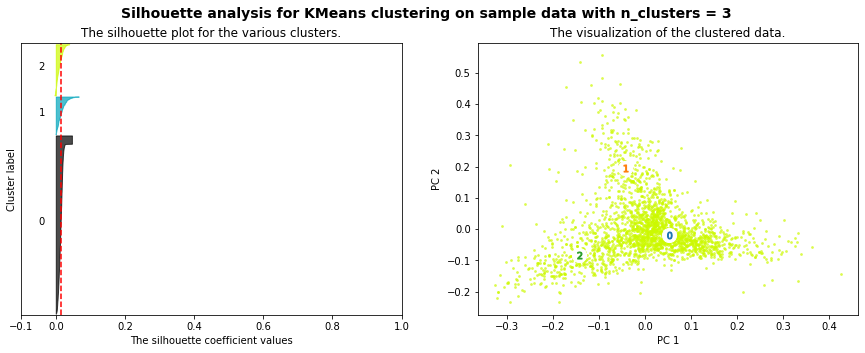

For n_clusters = 3, The average silhouette_score is : 0.014


In [ ]:
X = newsgroupsTFVects.toarray()
plotSilhouette(3, X)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


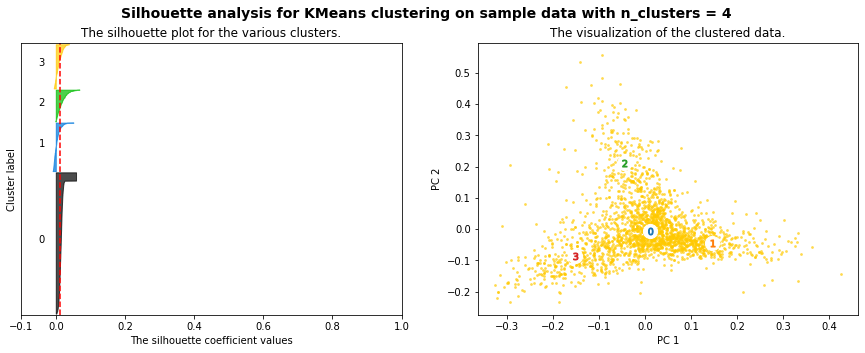

For n_clusters = 4, The average silhouette_score is : 0.012


In [ ]:
X = newsgroupsTFVects.toarray()
plotSilhouette(4, X)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


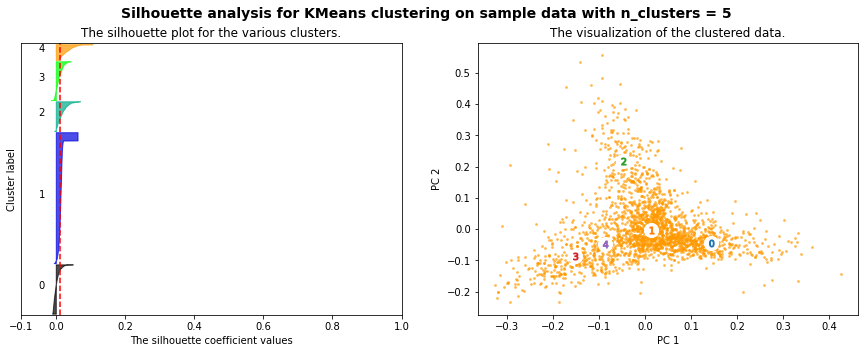

For n_clusters = 5, The average silhouette_score is : 0.013


In [ ]:
X = newsgroupsTFVects.toarray()
plotSilhouette(5, X)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


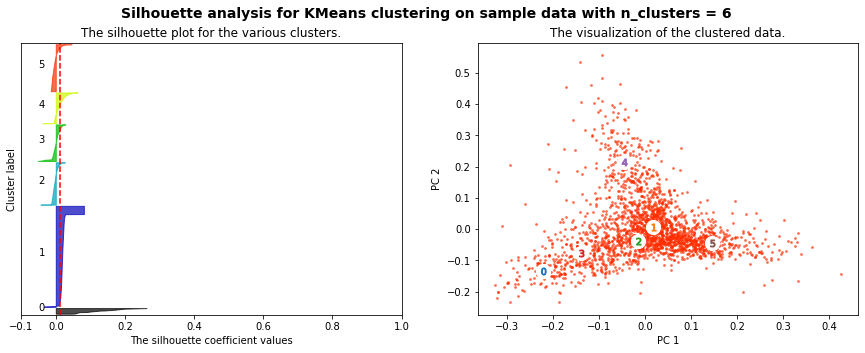

For n_clusters = 6, The average silhouette_score is : 0.011


In [ ]:
X = newsgroupsTFVects.toarray()
plotSilhouette(6, X)

Interestingly, the silhouette scores above suggests that 3 is a better number of clusters than 4, which would be accurate if we (reasonsably) grouped the two computer-themed groups.

# Getting new text data

Lets start by using the same function as last lesson and loading a few press releases from 10 different senators into a DataFrame. The code to do this is below, but commented out as we've already downloaded the data to the data directory.

In [ ]:
targetSenator = 'Kennedy'# = ['Voinovich', 'Obama', 'Whitehouse', 'Snowe', 'Rockefeller', 'Murkowski', 'McCain', 'Kyl', 'Baucus', 'Frist']
"""
#Uncomment this to download your own data
senReleasesTraining = pandas.DataFrame()

print("Fetching {}'s data".format(targetSenator))
targetDF = lucem_illud.getGithubFiles('https://api.github.com/repos/lintool/GrimmerSenatePressReleases/contents/raw/{}'.format(targetSenator), maxFiles = 2000)
targetDF['targetSenator'] = targetSenator
senReleasesTraining = senReleasesTraining.append(targetDF, ignore_index = True)

#Watch out for weird lines when converting to csv
#one of them had to be removed from the Kennedy data so it could be re-read
senReleasesTraining.to_csv("data/senReleasesTraining.csv")
"""

senReleasesTraining = pandas.read_csv("../data/senReleasesTraining.csv")

senReleasesTraining[:5]

Now we have the files we can tokenize and normalize.

The normalized text is good, but we know that the texts will have a large amount of overlap so we can use tf-idf to remove some of the most frequent words. Before doing that, there is one empty cell, let's remove that.

In [ ]:
senReleasesTraining = senReleasesTraining.dropna(axis=0, how='any')

In [ ]:
#Similar parameters to before, but stricter max df and no max num occurrences
senTFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=100, min_df=2, stop_words='english', norm='l2')
senTFVects = senTFVectorizer.fit_transform(senReleasesTraining['text'])
senTFVectorizer.vocabulary_.get('senat', 'Missing "Senate"')

# Clustering with our new data

One nice thing about using DataFrames for everything is that we can quickly convert code from one input to another. Below we are redoing the cluster detection with our senate data. If you setup your DataFrame the same way it should be able to run on this code, without much work.

First we will define what we will be working with

In [ ]:
targetDF = senReleasesTraining
textColumn = 'text'
numCategories = 3

Tf-IDf vectorizing

In [ ]:
exampleTFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=0.5, max_features=1000, min_df=3, stop_words='english', norm='l2')
#train
exampleTFVects = ngTFVectorizer.fit_transform(targetDF[textColumn])

Running k means

In [ ]:
exampleKM = sklearn.cluster.KMeans(n_clusters = numCategories, init='k-means++')
exampleKM.fit(exampleTFVects)

And visualize:

In [ ]:
examplePCA = sklearn.decomposition.PCA(n_components = 2).fit(exampleTFVects.toarray())
reducedPCA_data = examplePCA.transform(exampleTFVects.toarray())

colors = list(plt.cm.rainbow(np.linspace(0,1, numCategories)))
colors_p = [colors[l] for l in exampleKM.labels_]

In [ ]:
fig = plt.figure(1)
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(reducedPCA_data[:, 0], reducedPCA_data[:, 1], color = colors_p, alpha = 0.5)
plt.xticks(())
plt.yticks(())
plt.title('Predicted Clusters\n k = {}'.format(numCategories))
plt.show()

In this case, there may be two clusters that could be identified with Silhouette analysis or some of the metrics described above; although not having true classes makes that tricky. Below, we add these cluster assignments to the dataframe for individual perusal and evaluation.

In [ ]:
targetDF['kmeans_predictions'] = exampleKM.labels_
targetDF

## <font color="red">*Exercise 1*</font>

<font color="red">Construct cells immediately below this that construct features and cluster your documents using K-means and a variety of cluster numbers. Interrogate the cluster contents in terms of both documents and features. Identify the "optimal" cluster number with Silhouette analysis. Plot clusters and features after reducing with PCA. What does this cluster structure reveal about the organization of documents in your corpora? 

In [ ]:
import pandas as pd
import sklearn

In [ ]:
combined = pd.read_csv('sp_bb_combined.csv', index_col = 0)
#drop decades that have fewer than 1000 songs
combined = combined.drop(combined[combined['year_bin'].isin(['2020s', '1950s', '1960s'])].index.values)

Index(['title', 'artist', 'lyrics', 'tag', 'year', 'Gender', 'year_bin'], dtype='object')

In [ ]:
#Get a balanced dataset spread evenly across five decades
sample = combined.groupby('year_bin').sample(1352).reset_index(drop = True)

In [ ]:
sample.groupby('year_bin').count()

,title,artist,lyrics,tag,year,Gender,wald_predictions
year_bin,,,,,,,
1970s,1352,1352,1352,1352,1352,645,1352
1980s,1352,1352,1352,1352,1352,621,1352
1990s,1352,1352,1352,1352,1352,411,1352
2000s,1352,1352,1352,1352,1352,319,1352
2010s,1352,1352,1352,1352,1352,69,1352


In [ ]:
TFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=0.5, max_features=1000, min_df=3, stop_words='english', norm='l2')
TFVects = TFVectorizer.fit_transform(sample['lyrics'])
TFVectorizer.vocabulary_.get('fuck')

307

In [ ]:
TFVects.sum(axis = 1)

matrix([[4.66429006],
        [2.2105642 ],
        [4.32359567],
        ...,
        [3.82185137],
        [5.59490614],
        [2.16716863]])

In [ ]:
from scipy.sparse import *
import numpy as np
from scipy.sparse.linalg import norm
norm(TFVects, axis = 1)

array([1., 1., 1., ..., 1., 1., 1.])

In [ ]:
TFVectorizer.vocabulary_.get('bitch')

53

In [ ]:
PCA = sklearn.decomposition.PCA
pca = PCA(n_components = 2).fit(TFVects.toarray())
reduced_data = pca.transform(TFVects.toarray())

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


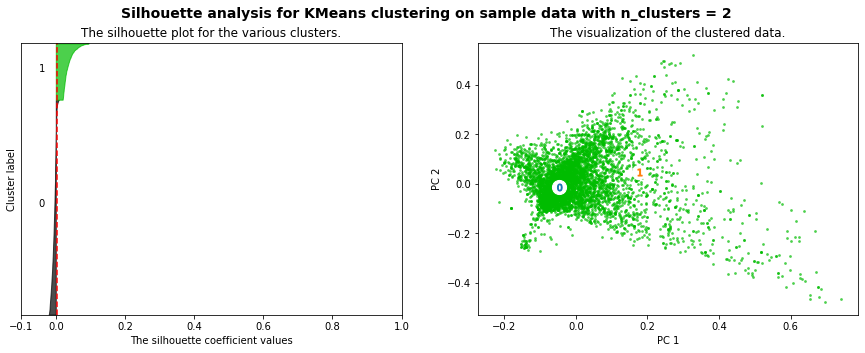

For n_clusters = 2, The average silhouette_score is : 0.003


In [ ]:
#examine the optimal number of clusters
X = TFVects.toarray()
plotSilhouette(2, X)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


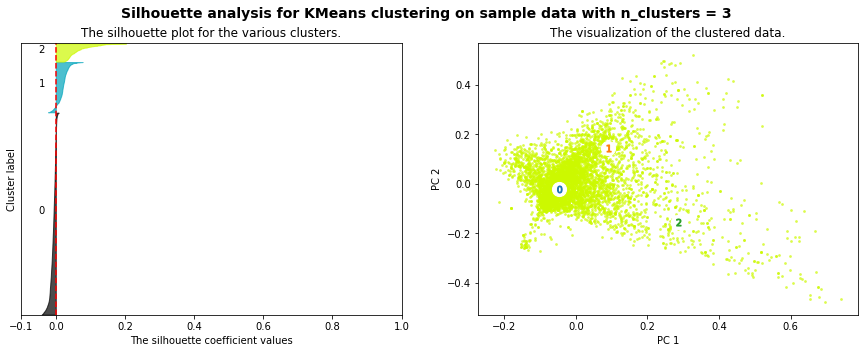

For n_clusters = 3, The average silhouette_score is : 0.002


In [ ]:
X = TFVects.toarray()
plotSilhouette(3, X)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


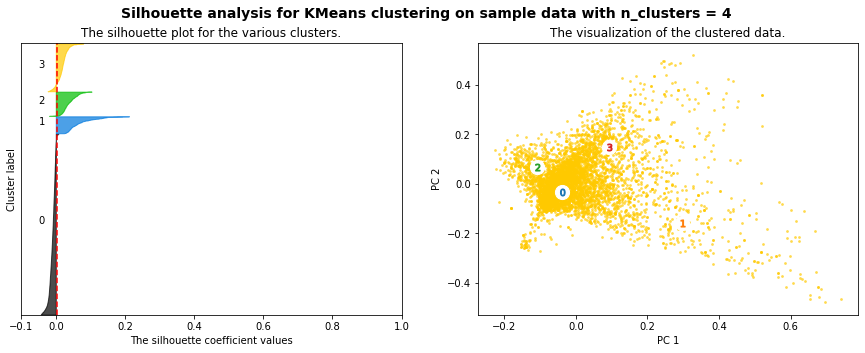

For n_clusters = 4, The average silhouette_score is : 0.004


In [ ]:
X = TFVects.toarray()
plotSilhouette(4, X)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


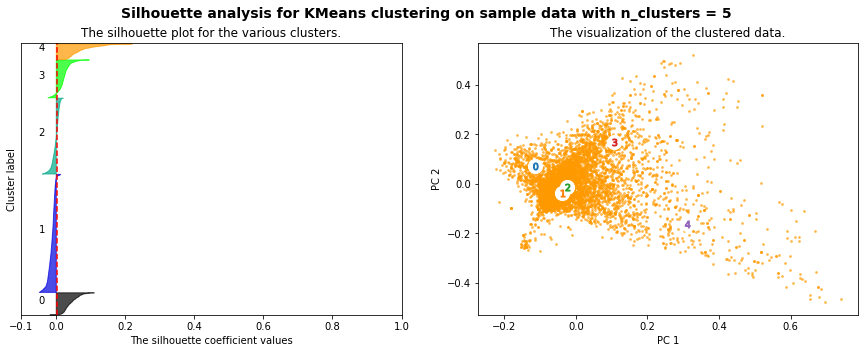

For n_clusters = 5, The average silhouette_score is : 0.005


In [ ]:
X = TFVects.toarray()
plotSilhouette(5, X)

From the silhouette score plots, it looks like cluster number = 3 is optimal. Now let's see what terms define each one cluster.

In [ ]:
numCluster = 3
terms = exampleTFVectorizer.get_feature_names()
print("Top terms per cluster:")
order_centroids = exampleKM.cluster_centers_.argsort()[:, ::-1] #flip the sequence of the column
for i in range(numCluster):
    print("Cluster %d:" % i)
    lyric = []
    for ind in order_centroids[i]:
      lyric.append(terms[ind])

    print(' '.join(lyric))

Top terms per cluster:
Cluster 0:
ll got yeah time ve let way cause say away life make feel come oh ain gonna want night day right man heart tell need think world na eyes won said long good mind wanna nigga la hey home little hold look shit things better ya niggas baby going turn hear gone girl tonight head rock ooh gotta new leave run stop light da real money live em really stay thing fall fuck bitch believe people feeling hard dance try bad song did play inside uh free ah face old high didn die walk left remember break coming used boy big lost wrong stand yo everybody hand change end sun sky rain dream place sweet maybe bring forever waiting looking woman best yes far alright lonely thought care wait hit round living ride true days talk help crazy hands smile young cold running pain open friend words makes door dreams bout lose told roll comes touch god close til sure came start heaven fly black soul somebody knew watch mean getting sing today wish beat hot whoa music boys game late 

Top terms for each cluster roughly looks somewhat similar. Let's dig deeper into the most representative observations in each cluster as measured by the distance to cluster center.

In [ ]:
#calculate distance to cluster center for all documents
from scipy.spatial.distance import cdist
min_dist = np.min(cdist(TFVects.toarray(), exampleKM.cluster_centers_, 'euclidean'), axis=1)
sample['dist_center'] = min_dist

In [ ]:
sample['k3label'] = exampleKM.labels_
grouped = sample[['dist_center', 'k3label']].groupby(['k3label'])
grouped.idxmin()

,dist_center
k3label,
0,14606
1,17669
2,2401


In [ ]:
#song index 14606 was the most representative song in cluster 0
print(sample.loc[14606,:])
print('Lyric:', sample.loc[14606,'lyrics'])

title                     Turbo Killer
artist                  Carpenter Brut
lyrics         You're the turbo killer
tag                                pop
year                              2017
Gender                             NaN
year_bin                         2010s
k2label                              0
dist_center                   0.187379
k3label                              0
Name: 14606, dtype: object
Lyric: You're the turbo killer


In [ ]:
#song index 17669 was the most representative song in cluster 1
print(sample.loc[17669,:])
print('Lyric:', sample.loc[17669,'lyrics'])

title                               I'll Give All My Love To You
artist                                               Keith Sweat
lyrics         Ooh, baby, baby, baby\nWhoa...oh...\nMy, my, m...
tag                                 ['american', 'rnb', 'urban']
year                                                        1991
Gender                                                      male
year_bin                                                   1990s
k2label                                                        1
dist_center                                             0.818211
k3label                                                        1
Name: 17669, dtype: object
Lyric: Ooh, baby, baby, baby
Whoa...oh...
My, my, my, my baby, yeah, girl
Oh, I love you, baby
Ooh, yes, I, yes, I do, girl

I love you in the night
I'm gonna take it real, real slow (Ooh, my baby)
I understand what you told me
And if I didn't know

I always wanted someone just like you
I really to hold you
I'd give the w

In [ ]:
#song index 2401 was the most representative song in cluster 2
print(sample.loc[2401,:])
print('Lyric:', sample.loc[2401,'lyrics'])

title                                      OMG (feat. will.i.am)
artist                                                     Usher
lyrics         Oh my gosh Baby let me I did it again, so I'm ...
tag                                                          edm
year                                                        2010
Gender                                                       NaN
year_bin                                                   2010s
k2label                                                        2
dist_center                                             0.639356
k3label                                                        2
Name: 2401, dtype: object
Lyric: Oh my gosh Baby let me I did it again, so I'm gon' let the beat rock Oh my Baby, let me love you down There's so many ways to love you Baby, I can break you down There's so many ways to love you Got me like, "Oh my gosh", I'm so in love I found you finally, you make me want to say Oh oh oh-oh oh, oh oh oh-oh oh Oh o

Examining the lyrics of the songs that are closest to cluster center, we can see that cluster 0 captures distinct words that are rare in the corpus: "killer" for example, is not a common word to be used in pop music. In fact, according to lyrical knowledge aggregator Genius,this particular song Turbo Killer by Carpenter Brut "acts as the voice in the head of a bloodthirsty cocaine addict about to go on a killing spree against a criminal organisation". On the contrary, cluster 1 and 2's representatives are more common love songs. The difference that cluster 1 is more desperate, devoted, kind of love: "I will never do anything to hurt you... only you.." while cluter 2's theme song OMG by Usher is more lighthearted and upbeat - "There's so many ways to love you Got me like, "Oh my gosh", I'm so in love I found you finally."

It seems that the clusters are identifying patterns associated with years

In [ ]:
sample.loc[sample.k2label == 0]

,title,artist,lyrics,tag,year,Gender,year_bin,k2label,dist_center,k3label
9920,Wild Horses,The Rolling Stones,Childhood living is easy to do The things you ...,rock,1971,NaN,1970s,0,0.991309,0
7442,Peace of Mind,Boston,Now if your feelin' kinda low 'bout the dues y...,rock,1976,NaN,1970s,0,0.970019,0
16245,Woodstock,Matthews' Southern Comfort,I came upon a child of God\nHe was walking alo...,"['british', 'english', 'uk']",1971,Group,1970s,0,0.968555,0
1159,Lowdown - Edit,Boz Scaggs,"Baby's into runnin' around, hangin' with the c...",rock,1976,NaN,1970s,0,1.000019,0
16235,Yo-yo,Osmonds,"Woah, oh, ho, just like a yo-yo\nWoah, oh, ho,...",['classic pop and rock'],1971,Group,1970s,0,0.987523,0
...,...,...,...,...,...,...,...,...,...,...
2532,Jackpot,Chico Rose,We hit the jackpot!Space junk Jackpot Space ju...,edm,2019,NaN,2010s,0,1.011705,0
2403,joy. (R3HAB Remix),for KING & COUNTRY,"Lately, I've been reeling, watching the nightl...",pop,2019,NaN,2010s,0,0.984989,0
11538,One For The Money,Escape the Fate,Are you ready? Are you ready? Are you ready? A...,rock,2013,NaN,2010s,0,0.997839,0
4874,Waste It On Me (feat. BTS),Steve Aoki,You say love is messed up You say that it don'...,pop,2018,NaN,2010s,0,0.999538,0


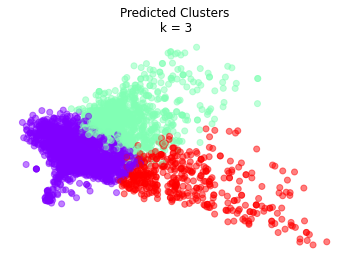

In [ ]:
numCluster = 3
targetDF = sample
textColumn = 'lyrics'
numCategories = numCluster
exampleTFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=0.5, max_features=1000, min_df=3, stop_words='english', norm='l2')
#train
exampleTFVects = exampleTFVectorizer.fit_transform(targetDF[textColumn])
exampleKM = sklearn.cluster.KMeans(n_clusters = numCategories, init='k-means++')
exampleKM.fit(exampleTFVects)
examplePCA = sklearn.decomposition.PCA(n_components = 2).fit(exampleTFVects.toarray())
reducedPCA_data = examplePCA.transform(exampleTFVects.toarray())

colors = list(plt.cm.rainbow(np.linspace(0,1, numCategories)))
colors_p = [colors[l] for l in exampleKM.labels_]

fig = plt.figure(1)
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(reducedPCA_data[:, 0], reducedPCA_data[:, 1], color = colors_p, alpha = 0.5)
plt.xticks(())
plt.yticks(())
plt.title('Predicted Clusters\n k = {}'.format(numCategories))
plt.show()

# Hierarchical Clustering with Wald's Method

Next we approach a hierchical clustering method, which proposes nested clusters at any resolution (at the finest resolution, every document is its own cluster).

Here we must begin by calculating how similar the documents are to one another.

As a first pass, we take our matrix of word counts per document
`newsgroupsTFVects` and create a word occurrence matrix measuring how similar
the documents are to each other based on their number of shared words. (Note one could perform the converse operation, a document occurrence matrix measuring how similar  words are to each other based on their number of collocated documents).

In [ ]:
newsgroupsTFVects

In [ ]:
newsgroupsTFVects[:100].todense()

In [ ]:
newsgroupsCoocMat = newsgroupsTFVects * newsgroupsTFVects.T
#set the diagonal to 0 since we don't care how similar texts are to themselves
newsgroupsCoocMat.setdiag(0)
#Another way of relating the texts is with their cosine similarity
#newsgroupsCosinMat1 = 1 - sklearn.metrics.pairwise.cosine_similarity(newsgroupsTFVects)
#But generally word occurrence is more accurate


Now we can compute a tree of nested clusters. Here we will only look at the first 50 texts of each class because drawing the dendrograms can be computationally intensive (and visually complex).

In [ ]:
selectIndices = []
indexToCat = []
for c in set(newsgroupsDF['category']):
    selectIndices += list(newsgroupsDF[newsgroupsDF['category'] == c].index)[:50]
    indexToCat += [c] * 50
    #.groupby('category').sum()

In [ ]:
subCoocMat = newsgroupsCoocMat[selectIndices,:][:,selectIndices]
linkage_matrix = scipy.cluster.hierarchy.ward(subCoocMat.toarray())
linkage_matrix[:10]

Now we can visualize the tree

In [ ]:
dendDat = scipy.cluster.hierarchy.dendrogram(linkage_matrix, get_leaves=True)

This plot may seem somewhat unwieldy. To make it easier to read, we can cut the tree after a number of branchings.

In [ ]:
dendrogramDat = scipy.cluster.hierarchy.dendrogram(linkage_matrix, p=4, truncate_mode='level', get_leaves=True)

By default, the tree is colored to show the clusters based on their ['distance'](https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.cluster.hierarchy.dendrogram.html#scipy.cluster.hierarchy.dendrogram) from one another, but there are other ways of forming hierarchical clusters.

Another approach involves cutting the tree into `n` branches. We can do this with [`fcluster()`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.fcluster.html#scipy.cluster.hierarchy.fcluster). Lets break the tree into 4 clusters. When we do this with all of the data in the dataframe, as below, we can add those clusters back for detailed evaluation.

In [ ]:
hierarchicalClusters = scipy.cluster.hierarchy.fcluster(linkage_matrix, 4, 'maxclust')
hierarchicalClusters

We can use this *get clusters* like we did with k-means. What if we do the full data set?

In [ ]:
linkage_matrix_full = scipy.cluster.hierarchy.ward(newsgroupsCoocMat.toarray())
hierarchicalClusters_full = scipy.cluster.hierarchy.fcluster(linkage_matrix_full, 4, 'maxclust')
print("For our complete clusters:")
print("Homogeneity: {:0.3f}".format(sklearn.metrics.homogeneity_score(newsgroupsDF['category'], hierarchicalClusters_full)))
print("Completeness: {:0.3f}".format(sklearn.metrics.completeness_score(newsgroupsDF['category'], hierarchicalClusters_full)))
print("V-measure: {:0.3f}".format(sklearn.metrics.v_measure_score(newsgroupsDF['category'], hierarchicalClusters_full)))
print("Adjusted Rand Score: {:0.3f}".format(sklearn.metrics.adjusted_rand_score(newsgroupsDF['category'], hierarchicalClusters_full)))

Not quite as good as k-means. Perhaps we've got too many words for Ward or maybe we shouldn't be using TFIDF as that compresses the space. Still, the hierarchical model places constraints on the clustering not present with k-means, which come at a cost. Finally, we can bring those cluster assignments back to the data frame for deeper investigation.

In [ ]:
newsgroupsDF['wald_predictions'] = hierarchicalClusters_full
newsgroupsDF

# Now let's do it with Senate press release data

We can also do hierarchical clustering with the Senate data. Let's start by creating the linkage matrix:

In [ ]:
exampleCoocMat = exampleTFVects * exampleTFVects.T
exampleCoocMat.setdiag(0)
examplelinkage_matrix = scipy.cluster.hierarchy.ward(exampleCoocMat[:100, :100].toarray())

And visualize the tree:

In [ ]:
ax = scipy.cluster.hierarchy.dendrogram(examplelinkage_matrix, p=5, truncate_mode='level')

Now let's do it with the entire data frame.

In [ ]:
example_linkage_matrix_full = scipy.cluster.hierarchy.ward(exampleCoocMat.toarray())
example_hierarchicalClusters_full = scipy.cluster.hierarchy.fcluster(example_linkage_matrix_full, 4, 'maxclust')

## <font color="red">*Exercise 2*</font>

<font color="red">Construct cells immediately below this that hierarchically cluster your documents using two approaches, and visualize them with a tree. Interrogate the recursive cluster contents in terms of both documents and closenesses. What does this nested cluster structure reveal about the organization of documents in your sampled corpora? Moreover, if they do worse than kmeans (as above), why do you think this is the case (hint: using metrics if you have ground truth or silhouette if you do not)? 

<font color="red">***Stretch***: Attempt using different distances into your clustering algorithms. (How) do they change the arrangement of clusters?

In [ ]:
CoocMat = TFVects * TFVects.T
CoocMat.setdiag(0)
linkage_matrix = scipy.cluster.hierarchy.ward(exampleCoocMat[:100, :100].toarray())

In [ ]:
CoocMat.shape

(6760, 6760)

In [ ]:
selectIndices = []
indexToCat = []
for c in set(sample['year_bin']):
    selectIndices += list(sample[sample['year_bin'] == c].index)[:50]
    indexToCat += [c] * 50
    #.groupby('category').sum()

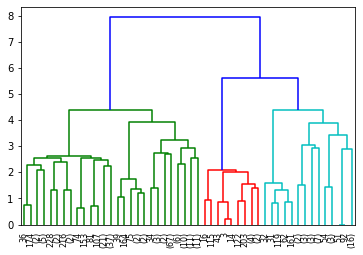

In [ ]:
subCoocMat = CoocMat[selectIndices,:][:,selectIndices]
linkage_matrix = scipy.cluster.hierarchy.ward(subCoocMat.toarray())
dendrogramDat = scipy.cluster.hierarchy.dendrogram(linkage_matrix, p=5, truncate_mode='level', get_leaves=True)

In [ ]:
dendrogramDat['ivl']

Let's do some qualitative examination of the dendrogram. It seems that the ward's method is clustering song 3 and 14 in the red cluster. Looking at the metadata of the songs and the lyrics, we can see that, the songs are both rock songs from 1978.

In [ ]:
print(sample.iloc[3])#.lyrics
sample.iloc[3].lyrics

title                                   Fool (If You Think It's Over)
artist                                                      Chris Rea
lyrics              A dying flame You're free again Who could love...
tag                                                              rock
year                                                             1978
Gender                                                            NaN
year_bin                                                        1970s
wald_predictions                                                    3
Name: 3, dtype: object


"A dying flame You're free again Who could love And do that to you? All dressed in black He won't be coming back Well, save your tears You've got years and years The pains of seventeens Unreal, they're only dreams Save your crying for the day Fool if you think it's over 'Cause you said goodbye Fool if you think it's over I'll tell you why New born eyes always cry with pain At the first look at the morning sun You're a fool if you think it's over It's just begun Miss Teenage Dream Such a tragic scene He knocked your crown And ran away First wound of pride And how you cried and cried But save your tears You've got years and years Fool if you think it's over 'Cause you said goodbye Fool if you think it's over I'll tell you why New born eyes always cry with pain At the first look at the morning sun You're a fool if you think it's over It's just begun (Fool if you think it's over) (Fool if you think it's over) I'll buy your first good wine We'll have a real good time Save your crying for th

In [ ]:
print(sample.iloc[14])#.lyrics
sample.iloc[14].lyrics

title               Once I Had A Love (AKA The Disco Song) - Remas...
artist                                                        Blondie
lyrics              Once I had a love and it was a gas Soon turned...
tag                                                              rock
year                                                             1978
Gender                                                            NaN
year_bin                                                        1970s
wald_predictions                                                    3
Name: 14, dtype: object


"Once I had a love and it was a gas Soon turned out to be a thing of the past Seemed like the real thing, only to find Mucho mistrust, love's gone behind Once I had a love and it was divine Soon found out I was losin' my mind Seemed like the real thing, but I was so blind Mucho mistrust, love's gone behind In between What I find is pleasin' and I'm feelin' fine Love is so confusing, there's no peace of mind If I fear I'm losin' you, it's just no good You teasin' like they would Once I had a love and it was a gas Soon turned out to be a thing of the past Seemed like the real thing, only to find Mucho mistrust, love's gone behind Lost inside Adorable illusion and I cannot hide I'm the one you're usin', please don't push me aside We could've made it cruisin', yeah Oh! ridin' high On love's true bluish lie Ooh-ooh-ooh, oh-oh Ooh-ooh-ooh, oh-oh Ooh-ooh-ooh, oh-oh Ooh-ooh-ooh, oh-oh Once I had a love and it was a gas Soon turned out to be a pain in the ass Seemed like the real thing, only to

The algorithm also clustered 39 and 164 to green cluster. Again, both songs are pop rock from 1976.


In [ ]:
print(sample.iloc[39])#.lyrics
sample.iloc[39].lyrics

title                                 Heaven Must Be Missing An Angel
artist                                                        Tavares
lyrics              Heaven must be missing an angel\nMissing one a...
tag                                          ['classic pop and rock']
year                                                             1976
Gender                                                          Group
year_bin                                                        1970s
wald_predictions                                                    1
Name: 39, dtype: object


"Heaven must be missing an angel\nMissing one angel, child, 'cause you're here with me right now\n(Your love is heavenly, baby)\n(Heavenly to me, baby)\n\nYour kiss, filled with tenderness\nI want all I can get of your sexiness\nShowers, your love comes in showers\nAnd every hour on the hour\nYou let me feel your loving power\n\nThere's a rainbow over my shoulder (ooh, ooh)\nWhen you came, my cup runneth over (ooh, ooh)\nYou gave me your heavenly love\nAnd if one night you hear crying from above\n\nIt's 'cause heaven must be missing an angel\nMissing one angel, child, 'cause you're here with me right now\n(Your love is heavenly, baby)\n(Heavenly to me, baby)\n\nOoh (heaven, heaven)\nOoh (heaven, heaven)\nOoh (heaven, heaven)\n(Heaven, heaven)\n\nOoh, I'm captured by your spell (ooh, ooh)\nYou're different, girl, I can tell (ooh, ooh)\nWhen you're laying on my pillow, baby\nAbove your pretty head, there's a halo, that's why I know\n\n(Heaven) must be missing an angel\n(Heaven) missing o

In [ ]:
print(sample.iloc[164])#.lyrics
sample.iloc[164].lyrics

title                                                      Disco Lady
artist                                                 Johnnie Taylor
lyrics              Shake it up, shake it down\nMove it in, move i...
tag                                         ['death by heart attack']
year                                                             1976
Gender                                                           male
year_bin                                                        1970s
wald_predictions                                                    1
Name: 164, dtype: object


"Shake it up, shake it down\nMove it in, move it 'round, disco lady\nMove it in, move it out\nMove it in, 'round about, disco lady\n\nShake it up, shake it down\nMove it in, move it around, disco lady, well\nHey sexy lady\nSaid I like the way you do your thang\nLord have mercy girl\n\nYou dance so fine and you're right on time\nGirl you ought to be on T.V., on Soul Train\nWhen you get the groove there ain't no stoppin'\nJust can't help it, but I'm finger poppin'\n\nShake it up, shake it down\nMove it in, move it 'round, disco lady, well\nMove it in, move it 'round\nMove it in, round about, disco lady\n\nShake it baby, shake it\nBaby shake your thang, one time\nShake it baby, shake it\nBaby shake your thang\n\nYou've got me groovin'\nI feel like movin'\nYou've got me movin'\nCan't sit still, I'm groovin' (I like that funky stuff)\n\nShake it up, shake it down\nMove it in, move it around, disco lady, well\nMove it in, move it out\nShove it in, 'round about, disco lady\n\nHey, sexy lady\n

Song 31 and 119 are also grouped together in the light blue cluster. Interestingly, looking the lyrics, both songs use "hell" a few times. I suspect occurance matrix formed by tfidf vectors would recognize these two corpus particularly similar due to the use of "hell".

In [ ]:
print(sample.iloc[31])
sample.iloc[31].lyrics


title                                             One Hell Of A Woman
artist                                                      Mac Davis
lyrics              Oh Lord it's hard to be humble\nWhen you're pe...
tag                                              ['pop country rock']
year                                                             1974
Gender                                                           male
year_bin                                                        1970s
wald_predictions                                                    1
Name: 31, dtype: object


"Oh Lord it's hard to be humble\nWhen you're perfect in every way.\nI can't wait to look in the mirror\nCause I get better loking each day.\nTo know me is to love me\nI must be a hell of a man.\nOh Lord it's hard to be humble\nBut I'm doing the best that I can.\nI used to have a girlfriend\nBut she just couldn't compete\nWith all of these love starved women\nWho keep clamoring at my feet.\nWell I prob'ly could find me another\nBut I guess they're all in awe of me.\nWho cares, I never get lonesome\nCause I treasure my own company.\nOh Lord it's hard to be humble\nWhen you're perfect in every way,\nI can't wait to look in the mirror\nCause I get better looking each day\nTo know me is to love me\nI must be a hell of a man.\nOh Lord it's hard to be humble\nBut I'm doing the best that I can.\nI guess you could say I'm a loner,\nA cowboy outlaw tough and proud.\nI could have lots of friends if I want to\nBut then I wouldn't stand out from the crowd.\nSome folks say that I'm egotistical.\nHel

In [ ]:
print(sample.iloc[119])
sample.iloc[119].lyrics


title                                                       You And I
artist                                                     Rick James
lyrics              You and I\nWe fit together like a glove on han...
tag                 ['boogie', 'contemporary r&b', 'disco', 'funk'...
year                                                             1978
Gender                                                           male
year_bin                                                        1970s
wald_predictions                                                    1
Name: 119, dtype: object


"You and I\nWe fit together like a glove on hand, that's right\nAnd don't you know\nThat I would gladly take you anywhere you wanted to go\nYou and me\nWe are as close as two part harmony, wouldn't you agree\nAnd given the chance\nOur romance in the end would surely be the end of me\n\n(Some people must say I'm infatuated with you\nI don't care 'cause they really don't know\nThey'll never see or hear the things I do with you\nSo far as I'm concerned they all can go to hell\nDoo, doo - doo, doo, doo\nDoo, doo - doo, doo, doo)\n\nYou and I\nWill be together 'til the six is nine, that's right\nAnd when you need me\nI never hesitate, I always come - it's so much fun\nYou and I\nAlthough we're poor our love has greater wealth than Hughes himself\nAnd given the chance\nThat there's an afterlife when we die, it's with you and I\n\n(Some people must say I'm infatuated with you\nI don't care 'cause they really don't know\nThey'll never see or hear the things I do with you\nSo far as I'm concern

In [ ]:
linkage_matrix_full = scipy.cluster.hierarchy.ward(CoocMat.toarray())
hierarchicalClusters_full = scipy.cluster.hierarchy.fcluster(linkage_matrix_full, 5, 'maxclust')
print("For our complete clusters:")
print("Homogeneity: {:0.3f}".format(sklearn.metrics.homogeneity_score(sample['year_bin'], hierarchicalClusters_full)))
print("Completeness: {:0.3f}".format(sklearn.metrics.completeness_score(sample['year_bin'], hierarchicalClusters_full)))
print("V-measure: {:0.3f}".format(sklearn.metrics.v_measure_score(sample['year_bin'], hierarchicalClusters_full)))
print("Adjusted Rand Score: {:0.3f}".format(sklearn.metrics.adjusted_rand_score(sample['year_bin'], hierarchicalClusters_full)))

For our complete clusters:
Homogeneity: 0.017
Completeness: 0.026
V-measure: 0.021
Adjusted Rand Score: 0.003


In [ ]:
sample['wald_predictions'] = hierarchicalClusters_full

Assuming the ground truth that clusters are divided by year_bin, the hierarchical cluster's performance is pretty good. Without such assumption, let's look at the silhouette score and plot.  For Kmean n_clusters = 5, the average silhouette_score is : 0.005. Let's see if hierarchical cluster is better.

In [ ]:
silhouette_avg = sklearn.metrics.silhouette_score(CoocMat.toarray(), hierarchicalClusters_full)

In [ ]:
silhouette_avg

0.08559924882839928

Nope! Hierarchical cluster's average sihouette score is much higher than the kmean's (0.085 >> 0.005)

# Gensim

To do topic modeling we will also be using data from the [grimmer press releases corpus](ttps://github.com/lintool/GrimmerSenatePressReleases). To use the texts with gensim we need to create a `corpua` object, this takes a few steps. First we create a `Dictionary` that maps tokens to ids.

Here again we make use of `lucem_illud` functions. The source code of both of these is in [processing.py](https://github.com/UChicago-Computational-Content-Analysis/lucem_illud/blob/main/lucem_illud/processing.py).

In [ ]:
#Apply our functions
senReleasesTraining['tokenized_text'] = senReleasesTraining['text'].apply(lambda x: lucem_illud.word_tokenize(x))
senReleasesTraining['normalized_tokens'] = senReleasesTraining['tokenized_text'].apply(lambda x: lucem_illud.normalizeTokens(x))

In [ ]:
senReleasesTraining[::100]

In [5]:
def dropMissing(wordLst, vocab):
    return [w for w in wordLst if w in vocab]


Then for each of the texts we create a list of tuples containing each token and its count. We will only use the first half of our dataset for now and will save the remainder for testing.

In [ ]:

#senReleasesTraining['reduced_tokens'] = senReleasesTraining['normalized_tokens'].apply(lambda x: dropMissing(x, senTFVectorizer.vocabulary_.keys()))
dictionary = gensim.corpora.Dictionary(senReleasesTraining['reduced_tokens'])
corpus = [dictionary.doc2bow(text) for text in senReleasesTraining['reduced_tokens']]

Then we serialize the corpus as a file and load it. This is an important step when the corpus is large.

In [ ]:
gensim.corpora.MmCorpus.serialize('senate.mm', corpus)
senmm = gensim.corpora.MmCorpus('senate.mm')

Now we have a correctly formatted corpus that we can use for topic modeling and induction.

In [ ]:
gensim.corpora.MmCorpus.serialize('senate.mm', corpus)
senmm = gensim.corpora.MmCorpus('senate.mm')
senlda = gensim.models.ldamodel.LdaModel(corpus=senmm, id2word=dictionary, num_topics=10, alpha='auto', eta='auto')

We can inspect the degree to which distinct texts load on different topics. Here is one of the texts from the training set:

In [ ]:
sen1Bow = dictionary.doc2bow(senReleasesTraining['reduced_tokens'][0])
sen1lda = senlda[sen1Bow]
print("The topics of the text: {}".format(senReleasesTraining['name'][0]))
print("are: {}".format(sen1lda))

We can now see which topics our model predicts press releases load on and make this into a `dataFrame` for later analysis.

In [ ]:
ldaDF = pandas.DataFrame({
        'name' : senReleasesTraining['name'],
        'topics' : [senlda[dictionary.doc2bow(l)] for l in senReleasesTraining['reduced_tokens']]
    })

This is a bit unwieldy so lets make each topic its own column:

In [ ]:
ldaDF = pandas.DataFrame({
        'name' : senReleasesTraining['name'],
        'topics' : [senlda[dictionary.doc2bow(l)] for l in senReleasesTraining['reduced_tokens']]
    })
#Dict to temporally hold the probabilities
topicsProbDict = {i : [0] * len(ldaDF) for i in range(senlda.num_topics)}

#Load them into the dict
for index, topicTuples in enumerate(ldaDF['topics']):
    for topicNum, prob in topicTuples:
        topicsProbDict[topicNum][index] = prob

#Update the DataFrame
for topicNum in range(senlda.num_topics):
    ldaDF['topic_{}'.format(topicNum)] = topicsProbDict[topicNum]

ldaDF[1::100]

Now let's visualize this for several (e.g., 10) documents in the corpus. First we'll subset the data:

In [ ]:
ldaDFV = ldaDF[:10][['topic_%d' %x for x in range(10)]]
ldaDFVisN = ldaDF[:10][['name']]
ldaDFVis = ldaDFV.as_matrix(columns=None)
ldaDFVisNames = ldaDFVisN.as_matrix(columns=None)
ldaDFV

First we can visualize as a stacked bar chart:

In [ ]:
N = 10
ind = np.arange(N)
K = senlda.num_topics  # N documents, K topics
ind = np.arange(N)  # the x-axis locations for the novels
width = 0.5  # the width of the bars
plots = []
height_cumulative = np.zeros(N)

for k in range(K):
    color = plt.cm.coolwarm(k/K, 1)
    if k == 0:
        p = plt.bar(ind, ldaDFVis[:, k], width, color=color)
    else:
        p = plt.bar(ind, ldaDFVis[:, k], width, bottom=height_cumulative, color=color)
    height_cumulative += ldaDFVis[:, k]
    plots.append(p)
    

plt.ylim((0, 1))  # proportions sum to 1, so the height of the stacked bars is 1
plt.ylabel('Topics')

plt.title('Topics in Press Releases')
plt.xticks(ind+width/2, ldaDFVisNames, rotation='vertical')

plt.yticks(np.arange(0, 1, 10))
topic_labels = ['Topic #{}'.format(k) for k in range(K)]
plt.legend([p[0] for p in plots], topic_labels, loc='center left', frameon=True,  bbox_to_anchor = (1, .5))

plt.show()

We can also visualize as a heat map:

In [ ]:
plt.pcolor(ldaDFVis, norm=None, cmap='Blues')
plt.yticks(np.arange(ldaDFVis.shape[0])+0.5, ldaDFVisNames);
plt.xticks(np.arange(ldaDFVis.shape[1])+0.5, topic_labels);

# flip the y-axis so the texts are in the order we anticipate (Austen first, then Brontë)
plt.gca().invert_yaxis()

# rotate the ticks on the x-axis
plt.xticks(rotation=90)

# add a legend
plt.colorbar(cmap='Blues')
plt.tight_layout()  # fixes margins
plt.show()

We can also look at the top words from each topic to get a sense of the semantic (or syntactic) domain they represent. To look at the terms with the highest LDA weight in topic `1` we can do the following:

In [ ]:
senlda.show_topic(1)

And if we want to make a dataFrame:

In [ ]:
topicsDict = {}
for topicNum in range(senlda.num_topics):
    topicWords = [w for w, p in senlda.show_topic(topicNum)]
    topicsDict['Topic_{}'.format(topicNum)] = topicWords

wordRanksDF = pandas.DataFrame(topicsDict)
wordRanksDF

We can see that several of the topics have the same top words, but there are definitely differences. We can try and make the topics more distinct by changing the $\alpha$ and $\eta$ parameters of the model. $\alpha$ controls the sparsity of document-topic loadings, and $\eta$ controls the sparsity of topic-word loadings.

We can make a visualization of the distribution of words over any single topic.

In [ ]:
topic1_df = pandas.DataFrame(senlda.show_topic(1, topn=50))
plt.figure()
topic1_df.plot.bar(legend = False)
plt.title('Probability Distribution of Words, Topic 1')
plt.show()

See how different $\eta$ values can change the shape of the distribution.

In [ ]:
senlda1 = gensim.models.ldamodel.LdaModel(corpus=senmm, id2word=dictionary, num_topics=10, eta = 0.00001)
senlda2 = gensim.models.ldamodel.LdaModel(corpus=senmm, id2word=dictionary, num_topics=10, eta = 0.9)
topic11_df = pandas.DataFrame(senlda1.show_topic(1, topn=50))
topic21_df = pandas.DataFrame(senlda2.show_topic(1, topn=50))

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(18, 7)
topic11_df.plot.bar(legend = False, ax = ax1, title = '$\eta$  = 0.00001')
topic21_df.plot.bar(legend = False, ax = ax2, title = '$\eta$  = 0.9')
plt.show()

### Heirarchial Dirichlet Process

We use LDA topic modeling above, but a similar alternative model you may run across is Hierarchical Dirichlet Processes, a nonparametric generalization of LDA. See, for example, [Teodoridis et al 2020](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3596233). One difference is how the researcher selects the number of topics.

In [ ]:
from gensim.models import HdpModel

In [ ]:
hdpmodel = HdpModel(corpus=corpus, id2word=dictionary)

In [ ]:
hdpmodel.print_topics()

[(0,
  '0.003*plai + 0.003*year + 0.003*game + 0.003*like + 0.003*season + 0.003*film + 0.003*star + 0.002*time + 0.002*team + 0.002*produc'),
 (1,
  '0.006*game + 0.006*film + 0.005*work + 0.004*time + 0.004*year + 0.003*said + 0.003*like + 0.003*right + 0.003*vote + 0.003*season'),
 (2,
  '0.005*like + 0.004*januari + 0.004*time + 0.004*spaghetti + 0.003*recip + 0.003*pasta + 0.003*look + 0.003*pan + 0.003*thank + 0.003*pie'),
 (3,
  '0.005*game + 0.003*season + 0.003*year + 0.003*content + 0.003*time + 0.003*team + 0.002*develop + 0.002*plai + 0.002*new + 0.002*point'),
 (4,
  '0.004*like + 0.003*film + 0.003*movi + 0.003*world + 0.003*year + 0.003*want + 0.002*car + 0.002*women + 0.002*time + 0.002*know'),
 (5,
  '0.004*game + 0.004*year + 0.003*team + 0.002*run + 0.002*april + 0.002*time + 0.002*season + 0.002*film + 0.002*world + 0.002*wai'),
 (6,
  '0.004*game + 0.003*like + 0.003*blazer + 0.003*year + 0.003*season + 0.003*olshei + 0.003*portland + 0.003*trail + 0.003*time + 0.0

Gensim sets the default number of topics as 150. This [stack overflow link](https://stackoverflow.com/questions/31543542/hierarchical-dirichlet-process-gensim-topic-number-independent-of-corpus-size) walks you through how to truncate these topics.

In [ ]:
hdptexts = hdpmodel[corpus]

In [ ]:
hdptexts[0]

[(6, 0.9978556642767126)]

This [HDP tutorial](https://towardsdatascience.com/dont-be-afraid-of-nonparametric-topic-models-part-2-python-e5666db347a) walks us through alternative HDP implementations outside of gensim.

## <font color="red">*Exercise 3*</font>

<font color="red">Construct cells immediately below this that topic model documents related to your anticipated final project. Interrogate and visually plot (e.g., as a bar graph?) the topic-word loadings and the document-topic loadings. What does this topic structure reveal about the distribution of contents across your documents? Systematically vary the $\alpha$, $\eta$, and topic number of the model for your text and describe in detail whether and how these changes led to distinctive outcomes, visible to you as analyst.  

<font color="red">**Stretch**: Cluster your documents, but instead of using words alone, use their topic loadings as an additional set of features. Do these topic loadings increase the apparent semantic coherence of your clusters?</font> 

In [2]:
import pandas as pd

combined = pd.read_csv('sp_bb_combined.csv', index_col = 0)
#drop decades that have fewer than 1000 songs
combined = combined.drop(combined[combined['year_bin'].isin(['2020s', '1950s', '1960s'])].index.values)
combined = combined.reset_index(drop = True)

In [6]:
#Apply our functions
combined['tokenized_text'] = combined['lyrics'].apply(lambda x: lucem_illud.word_tokenize(x))
combined['normalized_tokens'] = combined['tokenized_text'].apply(lambda x: lucem_illud.normalizeTokens(x))

In [7]:
TFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=0.5, max_features=1000, min_df=3, stop_words='english', norm='l2')
TFVects = TFVectorizer.fit_transform(combined['lyrics'])

In [8]:
combined['reduced_tokens'] = combined['normalized_tokens'].apply(lambda x: dropMissing(x, TFVectorizer.vocabulary_.keys()))
dictionary = gensim.corpora.Dictionary(combined['reduced_tokens'])
corpus = [dictionary.doc2bow(text) for text in combined['reduced_tokens']]

In [ ]:
dictionary.doc2bow(['lie', 'alive', 'lie'])

[(0, 1), (56, 2)]

In [ ]:
gensim.corpora.MmCorpus.serialize('lyric.mm', corpus)
lyricmm = gensim.corpora.MmCorpus('lyric.mm')
lyriclda = gensim.models.ldamodel.LdaModel(corpus=lyricmm, id2word=dictionary, num_topics=5, alpha='auto', eta='auto')

/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1023: RuntimeWarning: divide by zero encountered in log
  diff = np.log(self.expElogbeta)


In [ ]:
#pull a song and examine it's assigned topic probability
lyricBow_ = dictionary.doc2bow(combined['reduced_tokens'][0])
lyriclda_ = lyriclda[lyricBow_]
print("The topics of the text: {}".format(combined['title'][0]))
print("are: {}".format(lyriclda_))

The topics of the text: I Feel Alive
are: [(0, 0.1461529), (1, 0.06149307), (2, 0.7873668)]


In [ ]:
lyriclda

In [ ]:
ldaDF = pandas.DataFrame({
        'title' : combined['title'],
        'year_bin' : combined['year'],
        'tag' : combined['tag'],
        'topics' : [lyriclda[dictionary.doc2bow(l)] for l in combined['reduced_tokens']]
    })
#Dict to temporally hold the probabilities
topicsProbDict = {i : [0] * len(ldaDF) for i in range(lyriclda.num_topics)}

#Load them into the dict
for index, topicTuples in enumerate(ldaDF['topics']):
    for topicNum, prob in topicTuples:
        topicsProbDict[topicNum][index] = prob

#Update the DataFrame
for topicNum in range(lyriclda.num_topics):
    ldaDF['topic_{}'.format(topicNum)] = topicsProbDict[topicNum]

ldaDF[1::100]

,title,year_bin,tag,topics,topic_0,topic_1,topic_2,topic_3,topic_4
1,Poison,2005,r&b,"[(0, 0.14359549), (1, 0.5752782), (3, 0.063450...",0.143595,0.575278,0.000000,0.063451,0.216733
101,Cemetry Gates - 2011 Remaster,1986,rock,"[(0, 0.3178702), (2, 0.6757855)]",0.317870,0.000000,0.675785,0.000000,0.000000
201,Always on My Mind,1998,pop,"[(0, 0.7742142), (2, 0.22339933)]",0.774214,0.000000,0.223399,0.000000,0.000000
301,Boy I've Been Told,2006,latin,"[(0, 0.99235636)]",0.992356,0.000000,0.000000,0.000000,0.000000
401,Want You Back,2019,pop,"[(0, 0.5532129), (1, 0.16757135), (4, 0.276987...",0.553213,0.167571,0.000000,0.000000,0.276988
...,...,...,...,...,...,...,...,...,...
17901,Already Gone,2009,"['a filk artist', 'american idol', 'dance-pop'...","[(0, 0.9265636), (1, 0.06872819)]",0.926564,0.068728,0.000000,0.000000,0.000000
18001,Tonight,2011,"['dance', 'european', 'pop', 'pop and chart', ...","[(0, 0.6738275), (1, 0.295391), (4, 0.02848166)]",0.673828,0.295391,0.000000,0.000000,0.028482
18101,Domino,2012,"['pop', 'r&b', 'soul']","[(0, 0.08230465), (1, 0.8333162), (2, 0.021281...",0.082305,0.833316,0.021281,0.000000,0.062548
18201,22,2013,"['contemporary country', 'country', 'country p...","[(0, 0.17738293), (1, 0.74351335), (2, 0.07753...",0.177383,0.743513,0.077534,0.000000,0.000000


In [ ]:
ldaDFV = ldaDF[:10][['topic_%d' %x for x in range(5)]]
ldaDFVisN = ldaDF[:10][['title']]
ldaDFVis = ldaDFV.to_numpy()
ldaDFVisNames = ldaDFVisN.to_numpy()

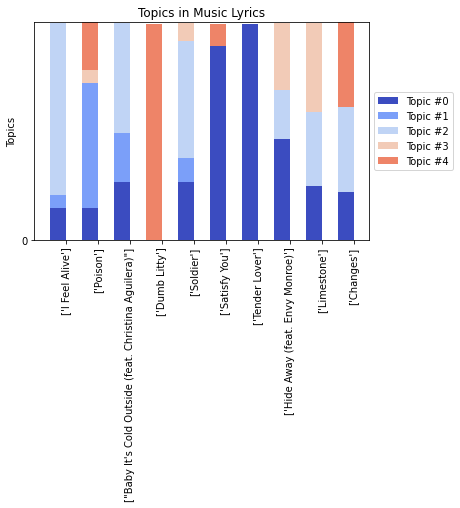

In [ ]:
N = 10
ind = np.arange(N)
K = lyriclda.num_topics  # N documents, K topics
ind = np.arange(N)  # the x-axis locations for the novels
width = 0.5  # the width of the bars
plots = []
height_cumulative = np.zeros(N)

for k in range(K):
    color = plt.cm.coolwarm(k/K, 1)
    if k == 0:
        p = plt.bar(ind, ldaDFVis[:, k], width, color=color)
    else:
        p = plt.bar(ind, ldaDFVis[:, k], width, bottom=height_cumulative, color=color)
    height_cumulative += ldaDFVis[:, k]
    plots.append(p)
    

plt.ylim((0, 1))  # proportions sum to 1, so the height of the stacked bars is 1
plt.ylabel('Topics')

plt.title('Topics in Music Lyrics')
plt.xticks(ind+width/2, ldaDFVisNames, rotation='vertical')

plt.yticks(np.arange(0, 1, 10))
topic_labels = ['Topic #{}'.format(k) for k in range(K)]
plt.legend([p[0] for p in plots], topic_labels, loc='center left', frameon=True,  bbox_to_anchor = (1, .5))

plt.show()

Here we see that the lda model assigns song "Dumb Litty" to Topic 4, which from the topicDict below seems to capture hip hop music. Indeed, the song was talking about having fun at parties by Korean hip hop artist KARD. The song "Tender Lover" was predominantly Topic 0. Looking at the high probability words from Topic 0 ('love', 'want','baby','feel','need', 'girl'), we can generalize Topic 0 as the apologetic, infatuated and intimate love song. The lyrics of "Tender Lover" supports such deduction. Other songs, like "Limestone" are pretty equally spread out across Topic 0, 2, and 3. 
Topic 2 and 3 are more upbeat love songs ('good', 'time', 'hand', 'dance', etc).
Topic 1 seems to be more romantic and sexual('night', 'baby', 'come', etc.). The song "Poison" by Bell Biv Devoe is predominantly Topic 1. 

In [ ]:
combined.loc[combined.title == "Tender Lover"]['lyrics'].values

array(["Feels good Everybody Tender lover Tender love Eleanor Rigby spends half her life All alone No fault of her own Made a decision Love has no place in her home Love It has a right to go Love has no limit If you believe in love It'll open up so Don't even give in 'Cause if it starts to give Just hold on We didn't didn't make it But love'll get you by If you only try Just don't give up on love 'Cause it didn't work out this time Tender lover Girl, I'm so sorry Well I never meant to hurt you I never meant to break your heart Tender love So broken hearted Well I never meant to break your Break your little tender heart Don't ever give up in spite of our love Love is much too precious It's greater than both of us There's more than enough Keep looking for love Just be a believer It'll give you what you want Sky is the limit If you believe in love It'll open up so Don't ever give in 'Cause if it starts to give Just hold on We didn't Didn't make it But love'll get you by If you only try Ju

In [ ]:
combined.loc[combined.title == "Limestone"]['lyrics'].values

array(["How many friends are you gonna set on fire? How many hearts are gonna end in flames? How many nights are you gonna play vampire Writing a book of crossed out names? I don't want to be alone Thinking about, thinking about the days I don't want to be alone Thinking about the days That you, you were running after me You, you were all the I could see How many lives are you gonna let expire? How many sparks of love have died in vain? How many nights will it take till you grow tired Hunting for the one that got away? I don't want to be alone Thinking about, thinking about the days I don't want to be alone Thinking about the days That you, you were running after me You, you were all the I could see Never never gonna make a home Sitting on a skull mountain throne Limestone, you'll be digging up, digging up the graves Limestone, you'll be digging up the graves That you, you were running after me You, and Louis Michelle Chablis You, you were all that I could see You, were light dancing o

In [ ]:
combined.loc[combined.title == "Poison"]['lyrics'].values

array(['NA Yeah, Spyderman and Freeze in full effect Uh-huh You ready, Ron? I\'m ready You ready, Biv? I\'m ready, Slick, are you? Oh, yeah, break it down NA Girl, I, must (warn you) I sense something strange in my mind Situation is (serious) Let\'s cure it cause we\'re running out of time It\'s oh, so (beautiful) Relationships they seem from the start It\'s all so (deadly) When love is not together from the heart It\'s drivin\' me out of my mind! That\'s why it\'s HARD for me to find Can\'t get it out of my head! Miss her, kiss her, love her(Wrong move you\'re dead!) That girl is (poison)...Never trust a big butt and smile That girl is (poison)..("POISON!!") NA (-caution) Before I start to meet a fly girl, you know? Cause in some (portions) You\'ll think she\'s the best thing in the world She\'s so - (fly) She\'ll drive you right out of your mind And steal your heart when you\'re blind Beware she\'s schemin\', she\'ll make you think you\'re dreamin\' YOU\'LL fall in love and you\'ll b

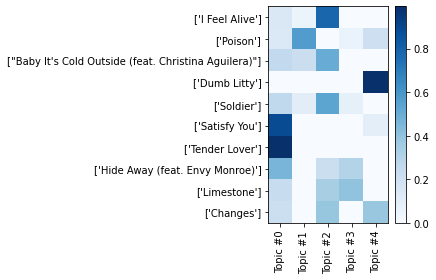

In [ ]:
plt.pcolor(ldaDFVis, norm=None, cmap='Blues')
plt.yticks(np.arange(ldaDFVis.shape[0])+0.5, ldaDFVisNames);
plt.xticks(np.arange(ldaDFVis.shape[1])+0.5, topic_labels);

# flip the y-axis so the texts are in the order we anticipate (Austen first, then Brontë)
plt.gca().invert_yaxis()

# rotate the ticks on the x-axis
plt.xticks(rotation=90)

# add a legend
plt.colorbar(cmap='Blues')
plt.tight_layout()  # fixes margins
plt.show()

In [ ]:
topicsDict = {}
for topicNum in range(lyriclda.num_topics):
    topicWords = [w for w, p in lyriclda.show_topic(topicNum)]
    topicsDict['Topic_{}'.format(topicNum)] = topicWords

wordRanksDF = pandas.DataFrame(topicsDict)
wordRanksDF

,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4
0,love,oh,good,na,yes
1,want,ooh,feel,gon,bitch
2,baby,yes,time,la,let
3,feel,baby,life,yes,girl
4,let,hey,da,come,fuck
5,need,night,hand,run,money
6,wanna,come,world,oh,nigga
7,time,ah,day,way,wanna
8,tell,let,live,uh,shit
9,girl,feel,yes,dance,man


As discussed above, the five topics can be interpreted as - 
Topic 0: tender, infatuated, sad, passionate， affectionate love songs;
Topic 1: romantic, sexual and desires songs
Topic 2 & 3: upbeat, celebratory songs
Topic 4: songs use profanity, hip hop

As my project focuses on the use of misogyny and other profanities, songs that have probability of belonging to Topic 4 would be particularlty interesting. In fact, close to 20% of all the 18373 songs are in Topic 4.

In [ ]:
len(ldaDF.loc[ldaDF.topic_4 > 0.5])/len(ldaDF)

0.1804822293582975

In [ ]:
def prob_dist(topic_num):
  topic1_df = pandas.DataFrame(lyriclda.show_topic(topic_num, topn=10))
  plt.figure()
  topic1_df.plot.bar(legend = False)
  plt.title('Probability Distribution of Words, Topic {}'.format(topic_num))
  plt.xticks()
  plt.xticks(range(10), topicsDict['Topic_{}'.format(topic_num)], rotation='vertical')
  plt.show()

<Figure size 432x288 with 0 Axes>

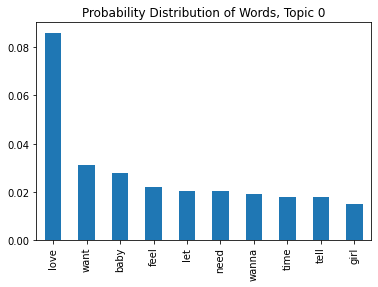

<Figure size 432x288 with 0 Axes>

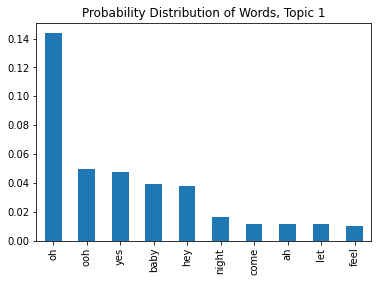

<Figure size 432x288 with 0 Axes>

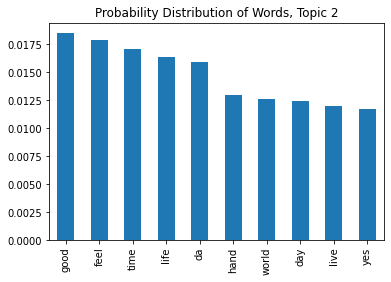

<Figure size 432x288 with 0 Axes>

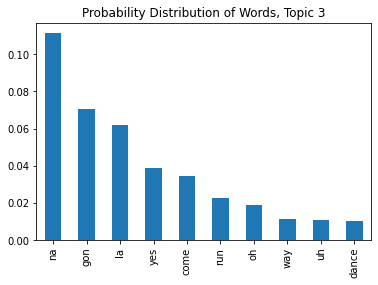

<Figure size 432x288 with 0 Axes>

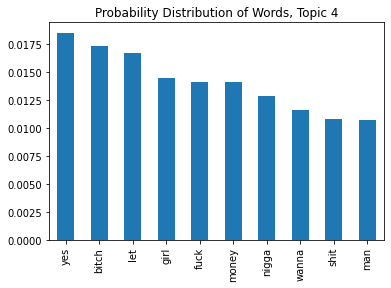

In [ ]:
for i in range(5):
  prob_dist(i)

/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1023: RuntimeWarning: divide by zero encountered in log
  diff = np.log(self.expElogbeta)


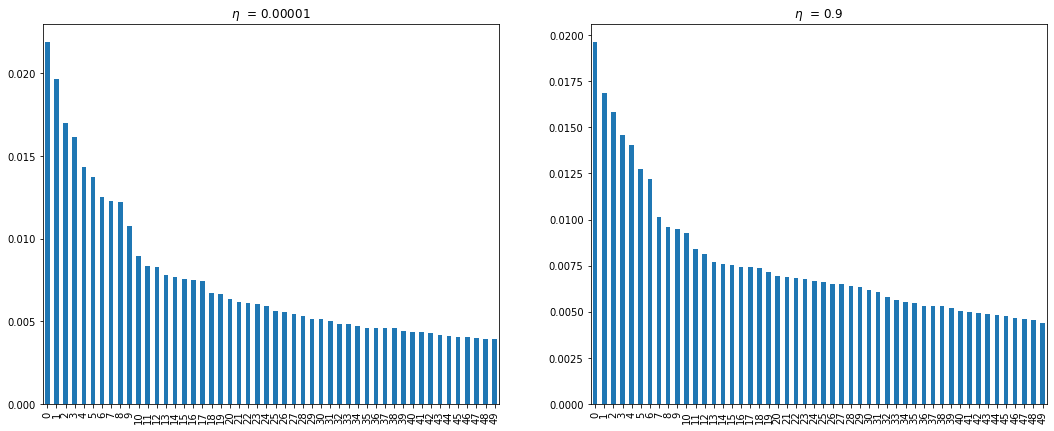

In [ ]:
lda1 = gensim.models.ldamodel.LdaModel(corpus=lyricmm, id2word=dictionary, num_topics=5, eta = 0.00001)
lda2 = gensim.models.ldamodel.LdaModel(corpus=lyricmm, id2word=dictionary, num_topics=5, eta = 0.9)
topic11_df = pandas.DataFrame(lda1.show_topic(0, topn=50))
topic21_df = pandas.DataFrame(lda2.show_topic(0, topn=50))

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(18, 7)
topic11_df.plot.bar(legend = False, ax = ax1, title = '$\eta$  = 0.00001')
topic21_df.plot.bar(legend = False, ax = ax2, title = '$\eta$  = 0.9')
plt.show()

In [ ]:
dictionary[0]

'alive'

In [ ]:
%%capture
!pip install pyLDAvis

In [ ]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(lyriclda, corpus, dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.090406  0.004535       1        1  29.302677
4     -0.114653 -0.075694       2        1  27.916059
2      0.091323 -0.081241       3        1  19.640427
1      0.041404  0.099163       4        1  14.580284
3     -0.108481  0.053236       5        1   8.560553, topic_info=      Term          Freq         Total Category  logprob  loglift
66      oh  56597.000000  56597.000000  Default  30.0000  30.0000
64      na  26462.000000  26462.000000  Default  29.0000  29.0000
15    love  60420.000000  60420.000000  Default  28.0000  28.0000
106    gon  20497.000000  20497.000000  Default  27.0000  27.0000
321     la  11843.000000  11843.000000  Default  26.0000  26.0000
..     ...           ...           ...      ...      ...      ...
94    away    880.342981  11681.763081   Topic5  -5.3529  -0.1275
163    ooh    913.434791  18465.652058   Topic5  -5.3160  -0.5485
305     ta    838.049343   9407.860906   Topic5  -5.4021   0.0398
86    time    883.031895  25046.432644   Topic5  -5.3499  -0.8871
85   thing    848.213601  12876.469323   Topic5  -5.3901  -0.2620

[350 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
708       1  0.010301    aah
708       4  0.003434    aah
708       5  0.985423    aah
314       1  0.097998     ah
314       2  0.082343     ah
...     ...       ...    ...
442       5  0.053081  young
648       1  0.021396    yuh
648       2  0.049923    yuh
648       4  0.003566    yuh
648       5  0.923575    yuh

[1236 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 5, 3, 2, 4])

The relevance (lambda) of a term given a topic is an adjustable metric that balances a term’s frequency in a particular topic against the term’s frequency across the whole corpus of documents. Lambda falls between 0 to 1. When lambda = 0, the relevance of word w given topic t is weighted by the frequency of the word across the entire corpus. In this case, words with high frequency globally would be downgraded heavily. When setting lambda to 1, the relevance of the word w is entirely determined by the frequency of the term in the topic. 


## Extending Topic Models within broader research pipelines

Topic models can be the base of more complex analysis. One good example is the paper - Individuals, institutions, and innovation in the debates of the French Revolution (https://www.pnas.org/content/115/18/4607), where they use topic models to find similarities and differences between the topics of different individuals. Let us revisit this idea using the Soap opera database. Who innovates and influences the most within the Soap?

The next few lines of code follows the same process as last weeks notebook. Please visit the old notebook to read descriptions of the code if you have forgotten what it does. `lucem_illud.loadDavies` can be found in [loaders.py](https://github.com/UChicago-Computational-Content-Analysis/lucem_illud/blob/main/lucem_illud/loaders.py).

In [ ]:
corpora_address = "/Users/bhargavvader/Downloads/Academics_Tech/corpora/SOAP"

In [ ]:
soap_texts = lucem_illud.loadDavies(corpora_address, num_files=2000)

In [ ]:
import zipfile
import pandas as pd

In [ ]:
zfile = zipfile.ZipFile(corpora_address + "/soap_sources.zip")
source = []

In [ ]:
for file in zfile.namelist():
    with zfile.open(file) as f:
        for line in f:
            source.append(line)

In [ ]:
soap_dict = {}

In [ ]:
for soap in source[3:]:
    try:
        textID, year, show, url = soap.decode("utf-8").split("\t")
    except UnicodeDecodeError:
        continue
    if show.strip() not in soap_dict:
        soap_dict[show.strip()] = []
    if show.strip() in soap_dict:
        try:
            soap_dict[show.strip()].append(soap_texts[textID.strip()])
        except KeyError:
            continue

In [ ]:
soap_dict.keys()

In [ ]:
soap_df = pd.DataFrame(columns=["Soap Name", "Tokenized Texts"])

In [ ]:
i = 0

In [ ]:
for soap in soap_dict:
    # since there were multiple lists
    print(soap)
    full_script = []
    for part in soap_dict[soap]:
        full_script = full_script + part
    soap_df.loc[i] = [soap, full_script]
    i += 1

In [ ]:
soap_df

Checking to see which index I should use. In my example it is the last one, so I choose my index as 9. It might be different for you!

In [ ]:
dool = soap_df['Tokenized Texts'][9]

In [ ]:
' '.join(dool[0:1500])

In [ ]:
characters = {}
for token in dool:
    if token[0] == '@':
        # all characters or actions start with @, so we add that to character
        if token[2:] not in characters:
            characters[token[2:]] = 0
        if token[2:] in characters:
            characters[token[2:]] += 1

In [ ]:
import networkx as nx

In [ ]:
actor_network = nx.Graph()

In [ ]:
for character in characters:
    if characters[character] > 2000:
        actor_network.add_node(character, lines_spoken= characters[character], words=[])

In [ ]:
i = 0

In [ ]:
all_texts = []

In [ ]:
for token in dool:
    i += 1
    if i > len(dool):
        break
    if token[0] == "@":
        if token[2:] in actor_network.nodes():
            j = i
            for token_ in dool[i:]:
                if token_[0] == "@":
                    # if both the characters exist in the graph, add a weight
                    if token_[2:] != token[2:] and token_[2:] in actor_network.nodes():
                        if (token[2:], token_[2:]) not in actor_network.edges():
                            actor_network.add_edge(token[2:], token_[2:], weight=0)
                        if (token[2:], token_[2:]) in actor_network.edges():
                            actor_network.edges[(token[2:], token_[2:])]['weight'] += 1
                    break
                j += 1
            # adding characters sentences
            actor_network.nodes[token[2:]]['words'].append(dool[i:j])
            all_texts.append(lucem_illud.normalizeTokens(dool[i:j]))

In [ ]:
nx.draw(actor_network, with_labels=True, font_weight='bold')

Ok - so we have our graph now. Let us create a topic model with all the texts spoken by the characters, see what's being spoken about, and construct topic distributions for each character. What does our all_texts corpus look like?

In [ ]:
all_texts[0:10]

In [ ]:
dictionary = gensim.corpora.Dictionary(all_texts)

In [ ]:
corpus = [dictionary.doc2bow(text) for text in all_texts]

In [ ]:
gensim.corpora.MmCorpus.serialize('dool.mm', corpus)
doolcorpus = gensim.corpora.MmCorpus('dool.mm')

In [ ]:
doollda = gensim.models.ldamodel.LdaModel(corpus=doolcorpus, id2word=dictionary, num_topics=10, alpha='auto', eta='auto')

In [ ]:
doollda.show_topics()

Are your topics interpretable/interesting? Sometimes they require a good deal of fine tuning and parameter choosing to get it to work in a nice way. Check out the gensim ldamodel documentation page and see what parameters you can play around with and try the model again!

In [ ]:
for actor in actor_network.nodes():
    actor_all_words = []
    for sent in actor_network.nodes[actor]['words']:
        for word in sent:
            actor_all_words += word
    actor_network.nodes[actor]['topic_distribution'] = doollda[dictionary.doc2bow(lucem_illud.normalizeTokens(actor_all_words))]

We now have topic distributions for each character. Let us have a brief look at what the characters are talking about. 

In [ ]:
for actor in actor_network.nodes():
    print(actor, actor_network.nodes[actor]['topic_distribution'])

Quickly eye-balling these distributions suggest that the model itself could be tuned better - all the topics are loaded more or less equally. 

In the paper I linked to earlier, they found similarities or differences using the KL divergence - this is a topic we've dealt with before. Let us plot a heatmap with these values.

In [ ]:
from gensim.matutils import kullback_leibler

In [ ]:
def convert_to_prob(bow):
    ps = []
    for topic_no, topic_prob in bow:
        ps.append(topic_prob)
    return ps

In [ ]:
L = []
for actor_1 in actor_network.nodes():
    p = actor_network.nodes[actor_1]['topic_distribution'] 
    p = convert_to_prob(p)
    l = []
    for actor_2 in actor_network.nodes():
        q = actor_network.nodes[actor_2]['topic_distribution'] 
        q = convert_to_prob(q)
        l.append(kullback_leibler(p, q))
    L.append(l)
M = np.array(L)

In [ ]:
fig = plt.figure()
div = pandas.DataFrame(M, columns = list(actor_network.nodes()), index = list(actor_network.nodes()))
ax = sns.heatmap(div)
plt.show()

This is one example of how we can use topic models to analyse a network - what other data exploration can you come up with?  Maybe see what are the themes surrounding the top topics for each of the actors? You now have the infrastructure to explore the network and the topics. Gensim has a great set of Jupyter Notebooks which illustrate their methods and functions - https://github.com/RaRe-Technologies/gensim/tree/develop/docs/notebooks. The Auto Examples page also has a good variety of examples - https://radimrehurek.com/gensim/auto_examples/. 


### Dynamic Topic Modelling

Dynamic Topic Modelling is a time based topic model method introduced by David Blei and John Lafferty. It allows one to see topics evolve over a time annotated corpus. I would recommend first viewing the Dynamic Topic Model tutorial on Gensim (https://github.com/RaRe-Technologies/gensim/blob/develop/docs/notebooks/ldaseqmodel.ipynb) to understand what exactly it's about. 

(An acknowledgement - Bhargav (the author of most of this class's code) wrote the code for Gensim's Dynamic Topic Models back in 2016 as a Google Summer of Code student, and they're still using it as are thousands of others!)

To demonstrate it on a time based corpus, we will create a corpus from COHA.

In [ ]:
corpora_address = "/Users/bhargavvader/Downloads/Academics_Tech/corpora/COHA"

In [ ]:
coha_texts = lucem_illud.loadDavies(corpora_address, return_raw=True)

In [ ]:
list(coha_texts.keys())[0:5]

We'd have to approach this differently: note that while extracting the corpus we returned the raw texts, and the dictionary keys already contain some useful information: the year published, and the genre. neat! We can now create some corpora, organised by year and by genre.

In [ ]:
coha_genres = {}
coha_years = {}

In [ ]:
for article in coha_texts:
    genre, year, id_ = article.split("_")
    if genre not in coha_genres:
        coha_genres[genre] = []
    if genre in coha_genres:
        coha_genres[genre].append(coha_texts[article])
    
    if year not in coha_years:
        coha_years[year] = []
    if year in coha_years:
        coha_years[year].append(coha_texts[article])
    

In [ ]:
coha_genres.keys()

In [ ]:
coha_years.keys()

That's neat: we have 4 genres and 200 years. We have to now decide how many time slices we want. Let us see how the corpus is distributed.

If you went through the tutorial, you would notice how we would need to arrange the corpora year wise.
We also have to arrange the number of topics per year.

In [ ]:
import collections

In [ ]:
years = []
year_lens = []

In [ ]:
for year_info in collections.OrderedDict(sorted(coha_years.items())):
    years.append(year_info)
    year_lens.append(len((coha_years[year_info])))

In [ ]:
years[0], years[-1]

In [ ]:
import matplotlib.pyplot as plt
plt.plot(years, year_lens)

The X axis isn't legible, but you can get the point: there are far less articles in the beginning, and then it grows. Maybe in our 5 time slices, we do: 1810-1880, 1881-1913, 1914-1950, 1950-1990, 1990-2009?
I use some historical intuition to use these time periods, you are encouraged to try your different time slices (for e.g, 20 10 year periods, 10 20 year periods, by total number of papers, etc)

In [ ]:
all_texts_coha = []
docs_per_timeslice = [0, 0, 0, 0, 0]
i = 0

In [ ]:
for year_info in collections.OrderedDict(sorted(coha_years.items())):
    large_files = 0
    for article in coha_years[year_info]:
        try:
            if len(article[2]) < 1500000:
                all_texts_coha.append(lucem_illud.normalizeTokens(article[2].decode("utf-8")))
            if len(article[2]) >= 1500000:
                large_files += 1
        except IndexError:
            continue
    # these numbers are the number of years in the 
    if i < 70:
        docs_per_year[0] += len(coha_years[year_info]) - large_files
    if i >= 70 and i < 103:
        docs_per_year[1] += len(coha_years[year_info]) - large_files
    if i >= 103 and i < 140:
        docs_per_year[2] += len(coha_years[year_info]) - large_files
    if i >= 140 and i < 180:
        docs_per_year[3] += len(coha_years[year_info]) - large_files
    if i >= 180:
        docs_per_year[4] += len(coha_years[year_info]) - large_files
    i += 1

#### Smaller Corpora

The original size of the corpus is wayyy too big for our laptops. Let us demo this with a smaller size. You are welcome to try different sizes until you get the size you would like.
I am using a 100 documents per time slice for this example.

In [ ]:
def choose_n(corpus, time_slices, nums=100):
    new_corpus = corpus[0:nums]
    for time_slice in time_slices[:-1]:
        new_corpus = new_corpus + corpus[time_slice:time_slice+nums]
    return new_corpus

Now, COHA also has some really large files, full books and the like: we're going to now split up really large files such that each of the documents are only 1000 tokens long. This function will return a split up document and the number of files it has been split into, so we can accordingly adjust the documents per time slice, which is important for Dynamic Topic Modelling to work.

In [ ]:
def split_up(document, doc_size=1000):
    new_docs = [document[i:i + doc_size] for i in range(0, len(document), doc_size)]
    return(new_docs, len(new_docs))

In [ ]:
small_corpus = choose_n(all_texts_coha, docs_per_year, nums=100)

In [ ]:
final_corpus= []

In [ ]:
docs_per_time_slice = [0, 0, 0, 0, 0]

I now use the split method to create my final corpus. Note that I hardcode values for the time slice to figure out the number of documets per time slice. Now I have a representative number of documents in each time slice. 

In [ ]:
for i, article in enumerate(small_corpus):
    # identify time slice based on article number 
    if i < 100:
        time = 0
    if i > 100 and i <= 200:
        time = 1
    if i > 200 and i <= 300:
        time = 2
    if i > 300 and i <= 400:
        time = 3
    if i > 400 and i <= 500:
        time = 4
        
    if len(article) > 1000:
        split_docs, no_docs = split_up(article)
        for doc in split_docs:
            final_corpus.append(doc)
        docs_per_time_slice[time] += no_docs
    else:
        final_corpus.append(article)
        docs_per_time_slice[time] += 1
    # just a check if the counts are correctly added
    if np.sum(docs_per_time_slice) != len(final_corpus):
        print(np.sum(docs_per_time_slice), len(final_corpus))

In [ ]:
dictionary = gensim.corpora.Dictionary(final_corpus)

In [ ]:
corpus = [dictionary.doc2bow(text) for text in final_corpus]

In [ ]:
gensim.corpora.MmCorpus.serialize('coha.mm', corpus)
cohacorpus = gensim.corpora.MmCorpus('coha.mm')

In [14]:
from gensim.models import ldaseqmodel

In [ ]:
ldaseq = ldaseqmodel.LdaSeqModel(corpus=corpus, id2word=dictionary, time_slice=docs_per_time_slice, num_topics=4)

In [ ]:
ldaseq.print_topics(time=0)[1]

In [ ]:
ldaseq.print_topics(time=4)[1]

What can you see from the analysis? I encourage you to explore the tutorial and see what else you can do with this dataset. In the above model I can see how the topic related to state evolves slowly, with the word president not previously there coming into the topic. I will now save this model and also upload it on GitHub so that you can see how it works. Note that the Dynamic Topic Model is a very time consuming algorithm: you might want to start a run overnight if you intend on using it in your analysis.

In [ ]:
ldaseq.save("ldaseqmodel")

In [ ]:
loaded_model = ldaseqmodel.LdaSeqModel.load("ldaseqmodel")

For future research, you can also consider the Structural Topic Model (STM), which can integrate any covariates (e.g., time, author, document length) into your topic model. Unfortunately there is not yet an implementation of this in Python, but there is a wonderful [R package](https://www.structuraltopicmodel.com/) authored by Molly Roberts, Brandon Stewart, and Dustin Tingley.

Here are plate diagrams of LDA and STM, which may help you visualize the way STM adds covariates to the "left" and "right" of the standard LDA model.

<img src="img/lda_stm_plate_diagrams.jpg" alt="img/lda_stm_plate_diagrams.jpg"/>



## <font color="red">*Exercise 4*</font>

<font color="red">Construct cells immediately below this that use dynamic topic models on datasets relevant to your final project. You can also extend the analysis of the COHA or Soap datasets, if relevant to the comparison of data for your projects. (You could possibly use coha_genres dictionary to conduct analysis on topic evolution for a particular genre? What themes do you see evolving throughout these corpora?)

Unfortunately, the dataset for my final project is not balanced across the years, even after removing the decades that have few observations.

In [ ]:
from gensim.models import CoherenceModel
def compute_coherence_values(corpus, dictionary, k):
    
    lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=k, 
                                           random_state=100)
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=combined['reduced_tokens'], dictionary=dictionary, coherence='c_v')
    
    return coherence_model_lda.get_coherence()

In [ ]:
%%capture
import numpy as np
import tqdm
grid = {}
grid['Validation_Set'] = {}
# Topics range
min_topics = 3
max_topics = 12
step_size = 1
topics_range = range(min_topics, max_topics, step_size)
'''
# Alpha parameter
alpha = list(np.arange(0.01, 1, 0.3))
alpha.append('symmetric')
alpha.append('asymmetric')
# Beta parameter
beta = list(np.arange(0.01, 1, 0.3))
beta.append('symmetric')
'''
# Validation sets
num_of_docs = len(corpus)

model_results = {'Topics': [],
                 'Coherence': []}
# Can take a long time to run
pbar = tqdm.tqdm(total=540)
# iterate through number of topics
for k in topics_range:
    print(k)
    cv = compute_coherence_values(corpus=corpus, dictionary=dictionary, k=k)
    # Save the model results
    model_results['Topics'].append(k)
    model_results['Coherence'].append(cv)
    
    pbar.update(1)
pd.DataFrame(model_results).to_csv('lda_tuning_results.csv', index=False)
pbar.close()

  0%|          | 1/540 [00:23<3:28:59, 23.26s/it]


In [ ]:
combined.year_bin.value_counts()

2010s    9864
2000s    3271
1990s    2248
1980s    1638
1970s    1352
Name: year_bin, dtype: int64

In [9]:
sample = combined.groupby('year_bin').sample(1352).reset_index(drop = True)

In [27]:
sample

,title,artist,lyrics,tag,year,Gender,year_bin,tokenized_text,normalized_tokens,reduced_tokens
0,Hello It's Me,Todd Rundgren,"Just gimme a... Gimme a break for a second 2,3...",rock,1972,NaN,1970s,"[Just, gimme, a, Gimme, a, break, for, a, seco...","[gimme, gimme, break, 2, ah-2, ah-1, hello, ha...","[gimme, gimme, break, hello, think, long, long..."
1,Department of Youth,Alice Cooper,We're in trouble all the time You read about u...,rock,1975,NaN,1970s,"[We, 're, in, trouble, all, the, time, You, re...","[trouble, time, read, paper, walk, bump, wall,...","[trouble, time, read, paper, walk, bump, wall,..."
2,I Wish,Stevie Wonder,Lookin' back on when I was a little nappy head...,"['contemporary r&b', 'funk', 'pop', 'pop soul'...",1977,male,1970s,"[Lookin, back, on, when, I, was, a, little, na...","[lookin, little, nappy, head, boy, worry, chri...","[lookin, little, head, boy, worry, thing, happ..."
3,'39 - 2011 Mix,Queen,In the year of '39 assembled here the Voluntee...,rock,1975,NaN,1970s,"[In, the, year, of, 39, assembled, here, the, ...","[year, assemble, volunteer, day, land, ship, s...","[year, day, land, blue, sweet, sight, night, f..."
4,Shining Star,"Earth, Wind & Fire","Yeah, hey, hey When you wish upon a star Your ...",r&b,1975,NaN,1970s,"[Yeah, hey, hey, When, you, wish, upon, a, sta...","[yes, hey, hey, wish, star, dream, far, yes, w...","[yes, hey, hey, wish, star, dream, far, yes, w..."
...,...,...,...,...,...,...,...,...,...,...
6755,Haunt,BANKS,What do you want? I wanna know You messed me u...,pop,2016,NaN,2010s,"[What, do, you, want, I, wanna, know, You, mes...","[want, wanna, know, mess, let, come, because, ...","[want, wanna, mess, let, come, way, crack, let..."
6756,Ex's & Oh's,Elle King,"Well, I had me a boy, turned him into a man I ...",pop,2015,NaN,2010s,"[Well, I, had, me, a, boy, turned, him, into, ...","[boy, turn, man, show, thing, understand, whoa...","[boy, turn, man, thing, understand, whoa, let,..."
6757,Be Your Man - Acoustic,Rhys Lewis,"Well, I could kiss you like he did Bet you wis...",r&b,2017,NaN,2010s,"[Well, I, could, kiss, you, like, he, did, Bet...","[kiss, like, bet, wish, lip, hold, guess, arm,...","[kiss, bet, wish, hold, guess, safe, cold, col..."
6758,Monster,LUM!X,Monster How should I feel? Creatures lie here ...,edm,2019,NaN,2010s,"[Monster, How, should, I, feel, Creatures, lie...","[monster, feel, creature, lie, look, window, m...","[feel, lie, look, window, feel, lie, look, win..."


In [11]:
docs_per_time_slice = sample.year_bin.value_counts().values.tolist()
docs_per_time_slice

[1352, 1352, 1352, 1352, 1352]

In [17]:
sample_dict = gensim.corpora.Dictionary(sample['reduced_tokens'])
sample_corpus = [sample_dict.doc2bow(text) for text in sample['reduced_tokens']]

In [18]:
%%capture
ldaseq = ldaseqmodel.LdaSeqModel(corpus=sample_corpus, id2word=sample_dict, time_slice=docs_per_time_slice, num_topics=5)

In [19]:
ldaseq.save("ldaseqmodel")

In [20]:
dic = {}
for t in range(5):
  dict[ldaseq.print_topics(time=t)[3]

Topic 3 is the one that contains lots of profanity and misogynistic words. Let's examine it across time.

In [34]:
dic = {'0': '1970s', '1': '1980s', '2': '1990s', '3': '2000s', '4': '2010s'}
topic_3 = pd.DataFrame(ldaseq.print_topic_times(topic = 3)).T.rename(columns = dic)

In [35]:
topic_3

,0,1,2,3,4
0,"(rock, 0.04114787299888193)","(rock, 0.030647913467305846)","(rock, 0.01801285379638191)","(yes, 0.017759894478515444)","(yes, 0.02961041001553998)"
1,"(money, 0.01718519775676386)","(nigga, 0.016983939550736224)","(nigga, 0.017394518340408727)","(nigga, 0.017745092026857156)","(nigga, 0.01790389393854375)"
2,"(nigga, 0.016643114053072464)","(shit, 0.014792145872512963)","(yo, 0.015577102047090905)","(fuck, 0.016658062255975967)","(fuck, 0.01762789649047395)"
3,"(roll, 0.016005182836907158)","(fuck, 0.014340004520087008)","(fuck, 0.015402858201094846)","(shit, 0.015874042999146066)","(bitch, 0.016197676329322258)"
4,"(shit, 0.014396136722991329)","(roll, 0.013911965010356781)","(shit, 0.015343657327114108)","(bitch, 0.015368706135296869)","(shit, 0.01615896167340668)"
5,"(fuck, 0.013708383502123812)","(yo, 0.013731697839548668)","(bitch, 0.014250942900138215)","(niggas, 0.013811168115140297)","(money, 0.014786668221647706)"
6,"(niggas, 0.01302770028472412)","(money, 0.013658939163340097)","(niggas, 0.013574015041771397)","(money, 0.012023594342906502)","(niggas, 0.013910787192281148)"
7,"(cause, 0.013022636475375044)","(bitch, 0.013330938932471429)","(yes, 0.012869966745761751)","(let, 0.011552627832228575)","(let, 0.011599168970728364)"
8,"(yes, 0.012864498952628775)","(niggas, 0.013279819382418697)","(let, 0.011364024636364533)","(come, 0.011048471290337918)","(come, 0.011022109056834569)"
9,"(bitch, 0.012796605761637336)","(cause, 0.012817334302770872)","(come, 0.011021478917232137)","(rock, 0.01084334405601926)","(uh, 0.010614252250869585)"


Interestingly, we see an increase in the frequency of the word "bitch" in this topic of lyrics overtime.